## _Network and Text Analytics upon the Hotel business reviews within Las Vegas, USA_

### _by Hanlu He, Sebastian Sbirna & Yingrui Li_
---
## Table of Contents:
- [__Part 1: Introduction and Motivation__](#1.)<br><br>
- [__Part 2: Dataset segmentation and cleaning__](#2.)
    - [2.1. <u>Stage 1: Filtering & subsetting from the full 10GB+ dataset</u>](#2.1.)
    - [2.2. <u>Stage 2: Performing data cleaning on the '_business_' dataframe</u>](#2.2.)
    - [2.3. <u>Filtering the dataset by geographic location and business category</u>](#2.3.)<br><br>
- [__Part 3: Descriptive statistics about the dataset__](#3.)<br><br>
- [__Part 4: Keyword detection using TF-IDF__](#4.)<br><br>
- [__Part 5: Network Analysis upon the Yelp hotel dataset__](#5.)
    - [5.1. <u>Creating the network graph</u>](#5.1.)
    - [5.2. <u>Visual plotting of the network graph</u>](#5.2.)
    - [5.3. <u>Degree distribution & comparison with random network</u>](#5.3.)
    - [5.4. <u>Network community detection & analysis</u>](#5.4.)
    - [5.5. <u>Community wordclouds</u>](#5.5.)<br><br>
- [__Part 6: Topic detection using LDA__](#6.)<br><br>
- [__Part 7: Sentiment Analysis upon the hotel reviews__](#7.)
    - [7.1. <u>Finding the sentiment trends</u>](#7.1.)
    - [7.2. <u>Temporal sentiment geomapping</u>](#7.2.)<br><br>
- [__Part 8: Discussion__](#8.)
---

<a id='1.'></a>
## 1. Introduction and Motivation

The ___Yelp___ online service is an application which stores, aggregates and displays crowdsourced reviews about businesses published in their internal database. One of main benefits of this service for its customers lies in the massive amounts of reviews which Yelp provides about a business, allowing its users to get an informed decision of whether a certain business fits their category of needs or not. However, when using the Web interface of the service, we have noticed some less-desired user experience choices, such as for example not setting a word limit to their reviews or only showing 10 businesses at a time on their comparison map. The lack of a review word limit has allowed reviews to become very generous in size, up to the point where it is difficult to get a quick overview about the performance of a business, since one is met by a "wall of text".

We have decided to use Data Science to improve upon these points, by providing interactive visualizations for the set of Yelp-relevant businesses across a defined area, as well as analyse their (many and lengthy) reviews automatically using Natural Language Processing, in order to get an informed idea on the top businesses which exist in a chosen geographical region, where Yelp also operates and is active.

---

The original dataset that we have selected to analyse this problem is the [Yelp dataset](https://www.yelp.com/dataset). This dataset contains a large subset of Yelp's businesses, reviews, check-ins and user-related public anonymous data. It was originally created for the Kaggle _Yelp Dataset Challenge_ which encouraged academics to conduct research or analysis on
the company's subset of data and show their discoveries to the world. 

The original __Yelp Academic Dataset__ contains information about 1.637.138 reviews collected from 192.609 businesses across 10 metropolitan areas in multiple countries of the world. Since this dataset is extremely large to work with (containing __10+ GB of data__), we have subsetted the data further into __one geographical area of interest: Las Vegas, US__, and __one business category: Hotels__. 

The reason for choosing Las Vegas as our geographical boundary is because it is the city in the dataset with most active Yelp user and business base, meaning that there is a large number of reviews and businesses signed up on the platform. Also, choosing Hotels was a choice of interest, since Las Vegas is famous for their 2-in-1 "Hotel & Casino" buildings and for their good services, so we wanted to understand more about the Hotel landscape in such a dynamic environment.

---

### __The main steps of this project will involve:__

1. Segmenting the dataset and cleaning it
    - <span style="color:green"> We will segment businesses to only include Las Vegas hotels </span>
    - <span style="color:green"> We will segment reviews to only include the ones directly related to our business </span><br><br>
2. Finding the top most important keywords which define each Hotel business in part, using the TF-IDF metric
    - <span style="color:green"> The top keywords will be detected by analysing all the reviews of each business in part </span><br><br>
3. Create a network of connected businesses, both statically in a graph-like visualization, as well as a geomap plot of the businesses we are targetting
    - <span style="color:green"> Two nodes (i.e. businesses) will be connected if they have a top keyword in common </span>
    - <span style="color:green"> The weight of the edges will be dependent on the total number of top keywords that the businesses share in common </span><br><br>
4. Identify relevant communities/clusters within the Hotels dataset, and plot their properties in graph, dynamic, as well as temporal visualizations<br><br>
5. Understand which businesses & communities are seen most positively or negatively, and look into how the sentiments evolve over period of day and year
    - <span style="color:green"> This will be done firstly by performing sentiment analysis on the reviews of our dataset </span>
    - <span style="color:green"> Secondly, this involves detecting the temportal change in sentiments across businesses </span>

---

<a id='2.'></a>
## 2. Dataset segmentation and cleaning

Before we delve into the deeper analysis of this project, let us import all the necessary libraries for this project:

In [1]:
# Basic libraries

import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import math
import time
import itertools

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Network libraries

import networkx as nx
from fa2 import ForceAtlas2 as FA2
import community

In [3]:
# NLP libraries

import re
import string
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.probability import FreqDist
from wordcloud import WordCloud, ImageColorGenerator

In [4]:
# Topic modeling libraries

import gensim
from gensim import corpora, models
import pyLDAvis
import pyLDAvis.gensim

warnings.simplefilter('ignore')

In [5]:
# Display libraries

from IPython.display import IFrame, display
from IPython.core.display import display as disp, HTML
from ipywidgets import widgets, interact, interactive, fixed, interact_manual
import imageio

from plotly import __version__
import plotly.io as pio
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import chart_studio.plotly as py
import plotly.offline
sns.set()

pio.renderers.default = 'notebook'

Now, we will proceed in filtering, subsetting and cleaning the original full Yelp Academic Dataset, according to the flowchart schema below:

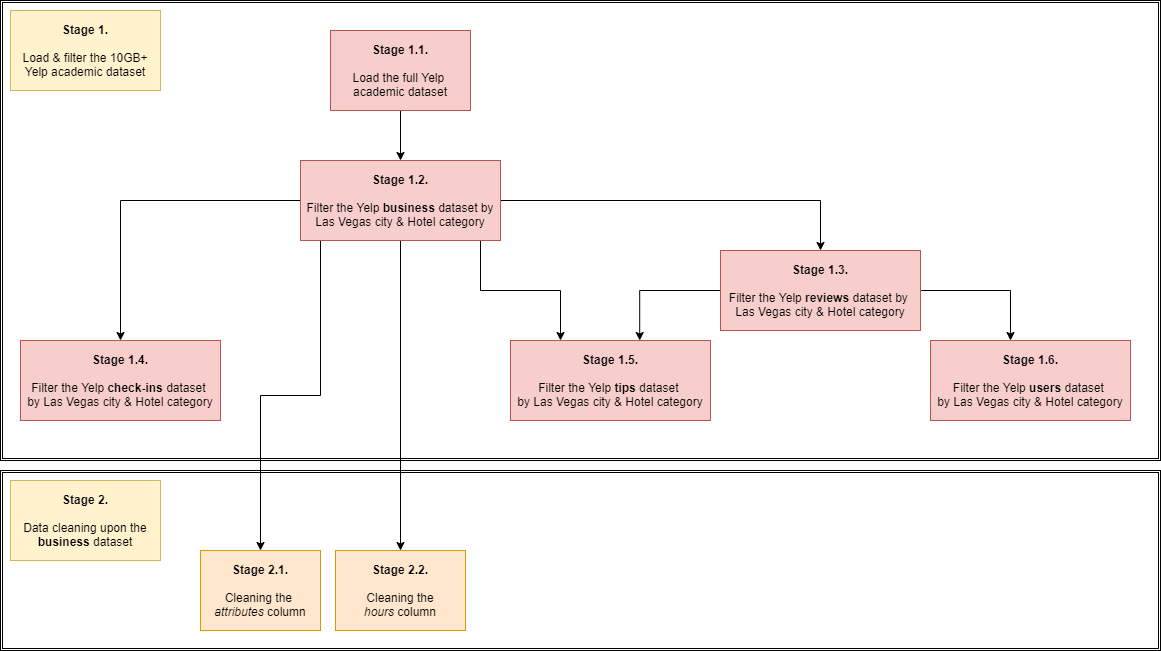

<a id='2.1.'></a>
### 2.1. Stage 1: Filtering & subsetting from the full 10GB+ dataset

_Here, we are filtering the 10GB+ original dataset into the subset selected specifically for our analysis, and saving the corresponding data subsets as individual CSV files:_

<a id='2.1.1.'></a>
#### 2.1.1. Stage 1.1: Loading the `business` dataframe:

First, we will load the dataframe containing all businesses in the Yelp dataset:

In [6]:
yelp_all_businesses_df = pd.read_json('yelp_dataset/yelp_academic_dataset_business.json', lines = True)

Let us check for the most proeminent cities within this dataset, meaning that they have most amount of businesses on the platform:

In [7]:
yelp_all_businesses_df.city.value_counts()

Las Vegas               31631
Toronto                 20366
Phoenix                 20171
Charlotte               10422
Scottsdale               9342
                        ...  
Redding                     1
Woodbridge (Vaughan)        1
Columbus                    1
NEWMARKET (OT)              1
Moon Twp.                   1
Name: city, Length: 1251, dtype: int64

We argue that, even though Yelp businesses are registered every day throughout major cities in the whole world, this is a subsetted dataset, which has been curated by Yelp for research purposes, and, in here, the city where most of the data is present is actually Las Vegas in Nevada, USA. 

Since we want to have some substantial amount of analysis data, we want to select a city where Yelp is popular and where it is used actively. Therefore, we will use Las Vegas as the target city where we will do our analysis in.

<a id='2.1.2.'></a>
#### 2.1.2. Stage 1.2: Subsetting the `business` dataframe for __Las Vegas__ data:

We are now interested in focusing our analysis on a specific city chosen for this project: **Las Vegas**.

In [8]:
all_business_las_vegas_df = yelp_all_businesses_df[yelp_all_businesses_df.city == 'Las Vegas']

# We want to drop businesses without any categories, since we won't be able to filter after them anyway
all_business_las_vegas_df = all_business_las_vegas_df.loc[all_business_las_vegas_df.categories.dropna().index]

We would like to save a dataset relative to all the ___Hotels___ in Las Vegas, in order to use it for review analysis and network creation:

In [9]:
hotels_las_vegas_df = all_business_las_vegas_df[all_business_las_vegas_df.categories.str.contains('Hotels')]

Next, we need to retrieve the ID list of all the Hotels in Las Vegas, in order to subset the subsequent datasets by business ID:

In [10]:
business_ids_all_business_las_vegas = list(all_business_las_vegas_df.business_id)
business_ids_hotels_las_vegas = list(hotels_las_vegas_df.business_id)

Finally, let us save the subsetted business dataset into its own CSV file:

In [11]:
all_business_las_vegas_df.to_csv('yelp_dataset/las_vegas_all_business.csv', index = False)
hotels_las_vegas_df.to_csv('yelp_dataset/las_vegas_hotel_business.csv', index = False)

In [12]:
del yelp_all_businesses_df
del all_business_las_vegas_df
del hotels_las_vegas_df

<a id='2.1.3.'></a>
#### 2.1.3. Stage 1.3: Subsetting the `reviews` dataframe for __Las Vegas__ data:

The *reviews* JSON file is very large (1.5GB+), and often is bound to give memory errors when trying to read it directly from using the specialized `read_json` functions of `pandas` or `dask`. Therefore, we need a more Python-traditional approach:

In [13]:
with open('yelp_dataset/yelp_academic_dataset_review.json', mode = 'r', encoding = 'utf8') as json_file:
    data = json_file.readlines()
    data = list(map(json.loads, data))
    
yelp_all_reviews_df = pd.DataFrame(data)

After we are able to load the data, we will filter the reviews and only keep the ones relevant to Las Vegas, in order to diminish its heavy memory consumption.

Initially, we will filter by all reviews relevant to all businesses in **Las Vegas**:

In [14]:
all_reviews_las_vegas_df = yelp_all_reviews_df[yelp_all_reviews_df.business_id.isin(business_ids_all_business_las_vegas)]

Next, we will also filter the reviews of hotels in Las Vegas:

In [15]:
hotels_reviews_las_vegas_df = all_reviews_las_vegas_df[all_reviews_las_vegas_df.business_id.isin(business_ids_hotels_las_vegas)]

Lastly, in order to filter the `Tips` and `Users` datasets, we will also store the IDs of the users writing all these reviews:

In [16]:
user_ids_all_reviews_las_vegas = list(all_reviews_las_vegas_df.user_id)
user_ids_hotels_las_vegas = list(hotels_reviews_las_vegas_df.user_id)

Let us save these 2 datasets for analysis at a later stage:

In [17]:
all_reviews_las_vegas_df.to_csv('yelp_dataset/las_vegas_all_reviews.csv', index = False)
hotels_reviews_las_vegas_df.to_csv('yelp_dataset/las_vegas_hotel_reviews.csv', index = False)

In [18]:
del yelp_all_reviews_df
del all_reviews_las_vegas_df
del hotels_reviews_las_vegas_df

<a id='2.1.4.'></a>
#### 2.1.4. Stage 1.4: Subsetting the `checkins` dataframe for __Las Vegas__ data:

Just like before, we will repeat identical steps for the `Checkins` dataset:

In [19]:
yelp_all_checkins_df = pd.read_json('yelp_dataset/yelp_academic_dataset_checkin.json', lines = True)
all_checkins_las_vegas_df = yelp_all_checkins_df[yelp_all_checkins_df.business_id.isin(business_ids_all_business_las_vegas)]
hotels_checkins_las_vegas_df = all_checkins_las_vegas_df[all_checkins_las_vegas_df.business_id.isin(business_ids_hotels_las_vegas)]

In [20]:
all_checkins_las_vegas_df.to_csv('yelp_dataset/las_vegas_all_checkins.csv', index = False)
hotels_checkins_las_vegas_df.to_csv('yelp_dataset/las_vegas_hotel_checkins.csv', index = False)

In [21]:
del yelp_all_checkins_df
del all_checkins_las_vegas_df
del hotels_checkins_las_vegas_df

<a id='2.1.5.'></a>
#### 2.1.5. Stage 1.5: Subsetting the `tips` dataframe for __Las Vegas__ data:

The same steps will be used for the `Tips` dataset:

In [22]:
yelp_all_tips_df = pd.read_json('yelp_dataset/yelp_academic_dataset_tip.json', lines = True)
all_tips_las_vegas_df = yelp_all_tips_df[(yelp_all_tips_df.business_id.isin(business_ids_all_business_las_vegas) & (yelp_all_tips_df.user_id.isin(user_ids_all_reviews_las_vegas)))]
hotels_tips_las_vegas_df = all_tips_las_vegas_df[(all_tips_las_vegas_df.business_id.isin(business_ids_hotels_las_vegas) & all_tips_las_vegas_df.user_id.isin(user_ids_hotels_las_vegas))]

In [23]:
all_tips_las_vegas_df.to_csv('yelp_dataset/las_vegas_all_tips.csv', index = False)
hotels_tips_las_vegas_df.to_csv('yelp_dataset/las_vegas_hotel_tips.csv', index = False)

In [24]:
del yelp_all_tips_df
del all_tips_las_vegas_df
del hotels_tips_las_vegas_df

<a id='2.1.6.'></a>
#### 2.1.6. Stage 1.6: Subsetting the `users` dataframe for __Las Vegas__ data:

Finally, precisely similar steps will also be used upon the `Users` dataset:

In [25]:
with open('yelp_dataset/yelp_academic_dataset_user.json', mode = 'r', encoding = 'utf8') as json_file:
    data = json_file.readlines()
    data = list(map(json.loads, data))
    
yelp_all_users_df = pd.DataFrame(data)

In [26]:
all_users_las_vegas_df = yelp_all_users_df[yelp_all_users_df.user_id.isin(user_ids_all_reviews_las_vegas)]
hotels_users_las_vegas_df = all_users_las_vegas_df[all_users_las_vegas_df.user_id.isin(user_ids_hotels_las_vegas)]

In [27]:
all_users_las_vegas_df.to_csv('yelp_dataset/las_vegas_all_users.csv', index = False)
hotels_users_las_vegas_df.to_csv('yelp_dataset/las_vegas_hotel_users.csv', index = False)

In [28]:
del yelp_all_users_df
del all_users_las_vegas_df
del hotels_users_las_vegas_df

<a id='2.2.'></a>
### 2.2. Stage 2: Performing data cleaning on the `business` dataframe

We need to read again the dataframes containing the businesses of Las Vegas, because we previously deleted them from memory, in order to make space for other operations:

In [29]:
las_vegas_all_business_df = pd.read_csv('yelp_dataset/las_vegas_all_business.csv')
las_vegas_hotel_business_df = pd.read_csv('yelp_dataset/las_vegas_hotel_business.csv')

<a id='2.2.1.'></a>
#### 2.2.1. Stage 2.1: Cleaning the `attributes` column:

Here, we will clean the `attributes` column into a JSON-parsable format:

In [30]:
def wrangle_attributes(row):
    attributes_data = row.attributes
    
    if (pd.isnull(attributes_data)):
        row['attributes'] = '{}'
        return row
        
    attributes_data = attributes_data.replace("\"u\'", "\'")
    attributes_data = attributes_data.replace('\'', '\"')
    attributes_data = attributes_data.replace('""', '"')
    attributes_data = attributes_data.replace('"{', '{')
    attributes_data = attributes_data.replace('}"', '}')
    attributes_data = attributes_data.replace(' False', ' "False"')
    attributes_data = attributes_data.replace(' True', ' "True"')
    attributes_data = attributes_data.replace(' None', ' "None"')
    
    row['attributes'] = attributes_data
    return row

Now, we will apply the above-created function to each row in the datasets, using a `lambda` function:

In [31]:
las_vegas_all_business_df = las_vegas_all_business_df.apply(lambda row: wrangle_attributes(row), axis = 1)

las_vegas_hotel_business_df = las_vegas_hotel_business_df.apply(lambda row: wrangle_attributes(row), axis = 1)

<a id='2.2.2.'></a>
#### 2.2.2. Stage 2.2: Cleaning the `hours` column:

Next, we need to properly convert the `hours` column into a fixed and consistent hour format:

In [32]:
def wrangle_hours(row):
    hours_data = row.hours
    
    if (pd.isnull(hours_data)):
        row['hours'] = '{}'
        return row
        
    hours_data = hours_data.replace('\'', '\"')
    hours_data = hours_data.replace('""', '"')
    hours_data = hours_data.replace('"{', '{')
    hours_data = hours_data.replace('}"', '}')
    hours_data = hours_data.replace(':0', ':00')
    
    row['hours'] = hours_data
    return row

Let us apply the time format conversion function to all necessary rows:

In [33]:
las_vegas_all_business_df = las_vegas_all_business_df.apply(lambda row: wrangle_hours(row), axis = 1)
las_vegas_hotel_business_df = las_vegas_hotel_business_df.apply(lambda row: wrangle_hours(row), axis = 1)

Lastly, we will save our updated datasets in place of the un-wrangled ones:

In [34]:
las_vegas_all_business_df.to_csv('yelp_dataset/las_vegas_all_business.csv', index = False)
las_vegas_hotel_business_df.to_csv('yelp_dataset/las_vegas_hotel_business.csv', index = False)

<a id='2.3.'></a>
### 2.3. Filtering the dataset by geographic location and business category

Let us remember that, previously, after every dataframe segmentation, we have deleted the dataframe from memory in order to free up resources for the subsequent parts of the cleaning process.

Therefore, now, let us reload only the dataframes which are of immediate interest, and, since we did not filter yet by either ___geographic location___ or ___business category___, we will need to take care of that now.

In [35]:
business_df = pd.read_csv('./yelp_dataset/las_vegas_all_business.csv')
review_df = pd.read_csv('./yelp_dataset/las_vegas_all_reviews.csv')
user_df = pd.read_csv('./yelp_dataset/las_vegas_all_users.csv')

Here, we will filter data according to a specific kind of business category (_Hotels_, in this case). However, the dificulty here rises, since there are two category types which we can encounter:

1. `Hotels & Travel`, which are referring to any kind of business directly or indirectly relating to the Hotel industry, including also car rentals services or Spas.


2. `Hotels`, which are referring specifically to the businesses providing lodging as an accredited Hotel. __This business category is the only one that we are interested in.__

Since one of the categories contains the name of the other, we have decided to solve this problem with the use of ___Regular Expressions___ for filtering the category:

In [36]:
# Filter the business_id according to the "Hotels" category
filter_business_id = business_df[business_df.categories.str.contains(r"(Hotels, )|(, Hotels$)", regex = True) == True].business_id

Now, we will re-update the business and review dataframes to only contain the filtered dataset:

In [37]:
# Update the business dataframe with only the relevant Hotel businesses
business_df = business_df[business_df.business_id.isin(filter_business_id)].reset_index().drop('index', axis = 1) \
                        .rename({'stars': 'stars_business'})

In [38]:
# Filter all the reviews based strictly on the 'business_id' corresponding to a Hotel's business_id
review_df = review_df[review_df.business_id.isin(filter_business_id)].reset_index().drop('index', axis = 1) \
                        .rename({'stars': 'stars_review'})

--- 
<a id='3.'></a>
## 3. Descriptive statistics about the dataset

After the full segmentation and cleaning has been performed, let us try to understand our dataset a little bit better. We will afterwards jump into the __Text Analytics__ part for finding important top business keywords, so it is important to know how large a  scale does our analysis have to deal with.

In [39]:
print('The total number of unique businesses/hotels in our dataset is:', business_df.shape[0])

The total number of unique businesses/hotels in our dataset is: 438


In [40]:
business_df.info(memory_usage = 'deep');

<class 'pandas.core.frame.DataFrame'>
Int64Index: 438 entries, 0 to 437
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   business_id   438 non-null    object 
 1   name          438 non-null    object 
 2   address       432 non-null    object 
 3   city          438 non-null    object 
 4   state         438 non-null    object 
 5   postal_code   438 non-null    float64
 6   latitude      438 non-null    float64
 7   longitude     438 non-null    float64
 8   stars         438 non-null    float64
 9   review_count  438 non-null    int64  
 10  is_open       438 non-null    int64  
 11  attributes    438 non-null    object 
 12  categories    438 non-null    object 
 13  hours         438 non-null    object 
dtypes: float64(4), int64(2), object(8)
memory usage: 452.7 KB


It seems that our Hotels dataframe contains __438 unique businesses__, which will also be the starting nodes for our network analysis graph later on. The dataframe uses about ~450 KB of memory, since we have filtered the dataset appropriately until we now a compact dataframe. The original `all_business` dataframe was requiring 20.3 MB of memory, which would not be a problem either.

The real challenge is working upon the large Reviews dataframe, since the original size of the `all_reviews` file was 1.6 GB alone. Let us see how many relevant reviews are we working with, and how large is our current dataset:

In [41]:
print('The total number of unique reviews (relating to the hotel businesses in our dataset) is:', review_df.shape[0])

The total number of unique reviews (relating to the hotel businesses in our dataset) is: 172159


In [42]:
review_df.info(memory_usage = 'deep');

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172159 entries, 0 to 172158
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   review_id    172159 non-null  object 
 1   user_id      172159 non-null  object 
 2   business_id  172159 non-null  object 
 3   stars        172159 non-null  float64
 4   useful       172159 non-null  int64  
 5   funny        172159 non-null  int64  
 6   cool         172159 non-null  int64  
 7   text         172159 non-null  object 
 8   date         172159 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 208.1 MB


As we can see from the memory usage footprint, the Reviews dataframe has also been reduced significantly in size to only 12.5% of the original size, while the number of reviews we will be analyzing is kept at a larger scale. This is really relevant, since more reviews will allow us to extract the important features when doing: __keyword detection, topic modeling, sentiment analysis__.

The network graph is highly dependent on the NLP analysis we will perform next. The nodes in our network will be connected depending on the amount of top keywords which their aggregated reviews have in common, therefore we cannot give a direct estimation of the number of edges in the network just yet. 

Let us move onwards to the TFIDF-powered keyword detection, in order to identify what kind of keywords are best representing each Hotel business, and what makes the businesses "stand out".

--- 
<a id='4.'></a>
## 4. Keyword detection using TF-IDF

Before we can analyze the aggregated reviews for each unique business, we would like to perform a JOIN operation on the `reviews` and the `business` dataframes, so that every review will also have metadata about the actual business that it is linked to. 

Since the `reviews` and the `business` dataframes share the common attribute `business_id`, we can JOIN the two tables/dataframes on that variable:

In [43]:
business_review_df = pd.merge(business_df, review_df, on = 'business_id', how = 'outer')
business_review_df.head(1)

business_id                        name                address  \
0  izw7OBVSeNmlVhjly1amQg  Wyndham Vacation Ownership  3475 Las Vegas Blvd S   

        city state  postal_code   latitude   longitude  stars_x  review_count  \
0  Las Vegas    NV      89109.0  36.119725 -115.172396      1.5           154   

   ...                                         categories hours  \
0  ...  Hotels & Travel, Hotels, Event Planning & Serv...    {}   

                review_id                 user_id stars_y useful  funny  cool  \
0  h4mPmRnFUgekEvtbvXMeWw  ANGEDyzIN7xlEOdxe5U5Wg     1.0      0      0     0   

                                                text                 date  
0  Went to the presentation and spent 4 hours the...  2018-06-19 18:13:32  

[1 rows x 22 columns]

When tokenizing the text of the reviews, we have performed multiple tests, and since we are dealing with user-written reviews of amenities they might have strong opinions on, the most important parts of speech for our analysis are: ___adjectives___. More specifically, the NLTK algorithm will consider an adjective to be any word which directly precedes a noun. A list of English nouns is predefined in their models.

Therefore, in order to remove neutral words and enhance the understanding of the customers' feelings towards hotels, the full text in a review has been tokenized and cleaned, yet only the adjectives in such a review have been extracted.

Also, since this decision has been made, we have also opted for not lemmatizing our wordset, since adjectives normally only have 1 single form of conjugating, therefore lemmatizing would be an unnecessary process for us.

The function below is responsible for the text parsing and cleaning, including operations such as:

* Tokenizing (separating long text into words/tokens)
* Removing punctuation and non-alphanumeric characters
* Removing stopwords (very frequenct English auxiliary words with no meaningful value)

In [44]:
# Function for tokenizing the text into a list of words

def tokenize_text(text):
    # Replace all the non-alphanumeric characters with space
    text = re.sub(r'[\W]', ' ', text)
    
    # Function to test if something is an adjective
    is_adj = (lambda pos: pos[:2] == 'JJ')

    # Tokenize texts into lists of tokens
    words = word_tokenize(text)    
   
    stop_words = set(stopwords.words('english'))
    
    # Remove punctuation and set words to lowercase
    words = [word.lower() for word in words if word not in string.punctuation]
    
    # Remove stopwords and letters (stopwords are lowercase, so this step should be done after word.lower())
    words = [word for word in words
                 if word not in stop_words
                 if len(word) > 1]    
    
    # Keep adjectives only
    words = [word for (word, pos) in nltk.pos_tag(words) if is_adj(pos)]

    return words

The function below has been written for two purposes: 

1. For a specific business, it concatenates all the individual reviews into one large string


2. For a specific community, (which we will discuss later in the Network Analysis part), it will concatenate all the reviews from businesses belonging to a community into one large string

In [45]:
def reviews(df, mode, dict_communities = None):
    
    if mode == 'community':
        # Create a dictionary for storing text of each community
        community_reviews = {}
        
        for comm in dict_communities.keys():
            community_text = ' '
            for business_id in dict_communities[comm]:
                business_text = ' '.join(df[df.business_id == business_id].text)
                community_text += business_text
                
            community_reviews[comm] = community_text
            
        return community_reviews
      
    if mode == 'business':
        # For each business, find its reviews
        business_reviews = {}
        
        for business_id in df.business_id.unique():      
            # Concatenate all reviews of a specific business into one text
            business_text = ' '.join(df[df.business_id == business_id].text)
            business_reviews[business_id] = business_text
            
        return business_reviews

In the next code paragraphs, we create functions for calculating some of the most important NLP metrics for our review analysis: the TF score, the IDF score, and their combined TF-IDF metric upon the aggregated reviews for each unique Hotel.

First, we will define how to compute the Term Frequency for each word, which is simply a frequency count for each of the words.

From literature, we can find numerous ways of calculating the weights of terms which can be applied:

* __Raw count__: This method simply counts the occurrence of each word.


* __Term frequency__: This method takes the total number of words of each document into account. For instance, if the counts of a word is high, but not high comparing to the total amount of words shown in a text, then this word is likely to not be too important.


* __Log__: This method uses the logarithm scale, which manages to shrink the difference of weights between highly frequent words and less frequent ones.


* __Double normalization__: This method aims to mitigate the case that we observe higher term frequencies in longer documents, merely because longer documents tend to repeat the same words over and over again.

In [46]:
# Function for computing TF (using different methods)

def tf(reviews, tf_method):

    # Create a nested dictionary {business: {word: tf score}} or {business: {word: tf score}} for storing term-frequency
    term_frequency = {}

    for comm, review in reviews.items():
        # Create a dictionary for each either community or business to store words and counts of words
        term_frequency[comm] = {}

        # Total word amount for one business (for tf_method=='term_frequency')
        total_word_amount = len(review)
        
        # Tokenize the text into a list of words
        words = tokenize_text(review)
        
        # Count words
        for word in words:
            if word not in term_frequency[comm].keys():
                term_frequency[comm][word] = 1
            else:
                term_frequency[comm][word] += 1       

        # Compute different types of term frequency
        if tf_method == 'raw_count':
            term_frequency = term_frequency

        elif tf_method == 'term_frequency':
            term_frequency[comm] = {k : v/total_word_amount for k, v in term_frequency[comm].items()}

        elif tf_method == 'log':
            term_frequency[comm] = {k : math.log(1 + v) for k, v in term_frequency[comm].items()}

        elif tf_method == 'double_normalization':
            term_frequency[comm] = {k : (0.5 + 0.5*v/max(term_frequency[comm].values())) for k, v in term_frequency[comm].items()}        

    return term_frequency

For our further analysis, we chose to use the ___`term frequency`___ calculation method for our scenarios, since it normalizes the original frequency (i.e. raw counts) by also considering the length of reviews.

This is very useful considering that the written reviews vary significantly in terms of their size and amount of words. In order to avoid words which would get high weights because they appear often in longer texts, the `term frequency` function will solve that problem by adjusting the score to the review length.

Next in our analysis, after the TF (Term Frequency) score is computed, we also need to define the computation of the IDF (Inverse Document Frequency) score, which measures how informative a word is across all the documents. 

Here we will implement two ways of calculating IDF scores: 

* __idf__: This method calculates the IDF score directly using the logarithm of the ratio $\frac{N}{n_t}$, where $N$ denotes the total number of documents, while $n_t$ denotes the number of documents where the word occurs in. If the IDF score is low, it means that the word is common not only in one document, but tends to show up in several documents. This suggests that such a word might not be informative.


* __idf_smooth__: This method is a modified version of original IDF, to solve the situation when a word occurs 0 times.

In [47]:
# Function for computing IDF (using different methods)

def idf(reviews, term_frequency, idf_method):
    
    # Total number of documents (i.e. total number of businesses in this case, because we concatenate all the reviews of one specific business)
    N = len(reviews.keys())
    
    # Create a nested dictionary for {business: {word: idf score}} storing term-frequency
    inverse_document_frequency = {}
    
    for comm1 in term_frequency.keys():
        # Update the idf dictionary into form as {business: {word: 0}}
        inverse_document_frequency[comm1] = {k : 0 for k in term_frequency[comm1].keys()}
        
        for word in term_frequency[comm1]:
            # If a specific word occurs in another business, add 1 to the count of this word
            for comm2 in term_frequency.keys():
                if word in term_frequency[comm2].keys():
                    inverse_document_frequency[comm1][word] += 1
        
        # Compute different types of inverse document frequency based on the number of occurance of a word in all the businesses
        if idf_method == 'idf':
            inverse_document_frequency[comm1] = {k : math.log(N/v) for k, v in inverse_document_frequency[comm1].items()}
        elif idf_method == 'idf_smooth':
            inverse_document_frequency[comm1] = {k : (math.log(N/(1+v))+1) for k, v in inverse_document_frequency[comm1].items()}
    
    return inverse_document_frequency

Lastly, the TF-IDF metric considers TF and IDF together by multiplying these two metrics in a word-wise fashion. TF shows how frequently a word occurs, while IDF could help to see whether the word is unique or not in corpus.

Let us define how to compute the TF-IDF scores for our reviews below, based on the TF and IDF scores retrieved from the earlier functions:

In [48]:
# Function for computing TD-IDF score
def tf_idf(term_frequency, inverse_document_frequency):
    
    tf_idf = {}
    for comm in term_frequency:
        tf_idf[comm] = {k : v*term_frequency[comm][k] for k, v in inverse_document_frequency[comm].items()}
    
    return tf_idf

Now that we have defined the necessary functions to perform the calculations of these metrics, let us run them upon our `reviews` dataset:

In [49]:
# Convert reviews of each business into one text for analysis

business_reviews = reviews(df = business_review_df, 
                           mode = 'business')

In [50]:
# Calculate term frequency for each business

business_term_frequency = tf(reviews = business_reviews, 
                             tf_method = 'term_frequency')

In [51]:
# Calculate inverse document frequency for each business

business_inverse_document_frequency = idf(reviews = business_reviews, 
                                          term_frequency = business_term_frequency, 
                                          idf_method = 'idf')

In [52]:
# Calculate TF-IDF score for each business

business_tf_idf = tf_idf(term_frequency = business_term_frequency,  
                         inverse_document_frequency = business_inverse_document_frequency)

By sorting the word terms descendingly by their TF-IDF score, we are able to find the top $N$ keywords which best identify and describe a particular hotel, based on all the reviews from its users. Let us create this function below.

In [53]:
# Function for extracting top keywords with highest TF-IDF score of each business
def retrieve_top_n_keywords(n, tf_idf_score = business_tf_idf):
    
    # Create a dictionary, which will contain top n keywords for each business
    top_keywords_dict = {}
    
    # For each business, we will save its business_id and its top n keywords in a dictionary
    for business_id, term_dict in tf_idf_score.items():
        
        # Sort the terms by their TF-IDF score (descendingly), and keep the top n keywords
        top_n_keywords_list = [tf_idf_tuple[0] for tf_idf_tuple in sorted(term_dict.items(), key = (lambda x : x[1]), reverse = True)][0:n]
        top_keywords_dict[business_id] = list(top_n_keywords_list)
        
    return top_keywords_dict

We will apply the function by appropriately selecting $N$, which is the number of top keywords that we want to retrieve from the TF-IDF term ranking.

At the same time, this number is essential for our Network Analysis, since $N$ dictates how many keywords each node will have available to check for matching with keywords of other nodes. The smaller the $N$ is selected to be, the fewer keywords will be available for nodes to match on and create edges between them, therefore a smaller number of top keywords will be directly proportional to a smaller number of edges created in our network.

In [54]:
n = 10
business_top_keywords = retrieve_top_n_keywords(n)

For the sake of easy retrieval, let us also store these top keywords of each business in the original `business` dataframe, in a new column.

In [55]:
# Add a column containing top keywords of each business to the original dataframe
business_df['top_keywords'] = business_df['business_id'].map(business_top_keywords)
business_df.head(1)

business_id                        name                address  \
0  izw7OBVSeNmlVhjly1amQg  Wyndham Vacation Ownership  3475 Las Vegas Blvd S   

        city state  postal_code   latitude   longitude  stars  review_count  \
0  Las Vegas    NV      89109.0  36.119725 -115.172396    1.5           154   

   is_open                                         attributes  \
0        1  {"BusinessAcceptsCreditCards": "True", "Restau...   

                                          categories hours  \
0  Hotels & Travel, Hotels, Event Planning & Serv...    {}   

                                        top_keywords  
0  [wyndham, timeshare, interested, drake, salesp...

--- 
<a id='5.'></a>
## 5. Network Analysis upon the Yelp hotel dataset  

<a id='5.1.'></a>
### 5.1. Creating the network graph

After we have determined the top $N$ most relevant keywords for each business in part, it is now time to investigate graph analytics upon the business network determined by the Yelp hotels.

The purpose of creating and visualizing such a network is to be able to identify hotels which are "connected" with each other by their unique words in their reviews, thereby identifying what each hotel is "distinguishing" itself compared to the others in the hotel landscape of Las Vegas. At the same time, two hotels/nodes who are strongly connected in our network can identify a potential "competitor" relationship between two businesses, since the hotels would share in common multiple distinguishing words.

First let us create the __undirected network graph__, where the nodes are our analyzed businesses:

In [57]:
G = nx.Graph()

# Add nodes
G.add_nodes_from(business_top_keywords.keys())
print('Initially, the total number of nodes/businesses in the network is:', G.number_of_nodes())

# Assign business name as an attribute to each node/business (for plotting it later)
for node in G.nodes:
    G.nodes[node]['business_name'] = business_df.name[business_df.business_id == node].values[0]

Initially, the total number of nodes/businesses in the network is: 438


We will remodel the "top keywords" dictionary into a dataframe in long-format, where each row corresponds to a (business_id, unique_keyword) combination. This specific form for the dataframe is necessary, so that we can group by keywords afterwards, and identify which businesses share a keyword in common.

In [58]:
keyword_df = pd.DataFrame(business_top_keywords).melt(var_name = 'business_id', value_name = 'keywords').reset_index()

In [59]:
# Group keywords by 'business_id', to find the businesses sharing top keywords

grouped_keyword_df = keyword_df.groupby(['keywords', 'business_id']).count()['index']

Here, we will connect the nodes by their keywords, creating edges. Also, the __weight of the edges__ will be taken into account as representing the total number of top keywords that two hotel businesses share in common.

In [60]:
# Here, we are iterating through the grouped set of keywords, 
# and if two businesses have the same keyword in common, we will create a network edge between the two busineses

for _, business_sub_df in grouped_keyword_df.groupby(level = 0):
    
    # This is a list of combinations of 2 businesses which have the same top keyword in common
    edges_list = list(itertools.combinations(business_sub_df.droplevel(0).index, 2))
    
    for node1, node2 in edges_list:
        
        if G.has_edge(node1, node2):
            # we added this connection before, just increase the weight by one
            G[node1][node2]['weight'] += 1
            
        else:
            # new edge, therefore initialize link with weight = 1
            G.add_edge(node1, node2, weight = 1)

In [61]:
print('Using the top n = %d keywords from TF-IDF, the initialized number of edges is: %d' % (n, G.number_of_edges()))

Using the top n = 10 keywords from TF-IDF, the initialized number of edges is: 10791


As we can see above, the number of edges connecting different parts of this network is quite large (> 10000 edges), especially since we have selected a more generous number ($N = 10$) of top keywords that the nodes are allowed to match on. The reason behind this choice is that if we decrease this number to 5 or 3 keywords, the degrees of the nodes in the graph will fall dramatically and there will be more isolated nodes in the graph, which is a behaviour we do not want.

Finally here, let us remove the (few) isolated nodes in the graph, locate the main connected component of the graph (GCC) and focus our analysis on specifically these kinds of nodes:

In [62]:
# Remove the isolated nodes from the graph
G.remove_nodes_from(list(nx.isolates(G)))

# Remove nodes outside the main connected component (i.e. outside the GCC)
for component in list(nx.connected_components(G.to_undirected())):
    if (len(component) < 5):
        for node in component:
            G.remove_node(node)

print('After removal of isolated or non-GCC nodes, the total number of nodes/businesses in the network is:', G.number_of_nodes())
print('Also, the number of edges present in the network now is:', G.number_of_edges())

After removal of isolated or non-GCC nodes, the total number of nodes/businesses in the network is: 421
Also, the number of edges present in the network now is: 10790


Through the code above, we have also presented preliminary descriptive statistics upon the network graph, which contains ___421 nodes___ which we are working with, as well as ___10790 edges___ connecting the various hotel busineses together.

<a id='5.2.'></a>
### 5.2. Visual plotting of the network graph

In order to visualize how the constructed graph looks like, we will use a __force-directed layout__ for our graph, based on the Force Atlas algorithm, which computes node positions spatializing our undirected weighted graph. 

The node positions will be calculated at the next step, before being fed into the plotting function.

In [123]:
# Create instance for FA2
forceatlas2 = FA2(scalingRatio = 100, gravity = 100, outboundAttractionDistribution = True)

# Calculate positions of nodes in the visualization
positions = forceatlas2.forceatlas2_networkx_layout(G, pos = None, iterations = 1000)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 80.92it/s]

BarnesHut Approximation  took  1.90  seconds
Repulsion forces  took  9.32  seconds
Gravitational forces  took  0.15  seconds
Attraction forces  took  0.29  seconds
AdjustSpeedAndApplyForces step  took  0.31  seconds


Here, we will also create a list of node sizes based on the total number of reviews that each hotel has, multiplied by a minimizing constant, so as to make the sizes reasonable to display. Therefore, very popular hotels will have higher node sizes than most others.

In [124]:
node_sizes = []

for node in G:
    
    total_reviews = business_df[business_df.business_id == node].review_count
    
    # Append the appropriate size to a node
    node_sizes.append(total_reviews * 0.025)

Finally, here we will plot the static graph visualization using networkx and matplotlib's underlying drawing functions. This graph helps us understand how connected the hotel business landscape in Las Vegas is, and also helps us identify what role in the network the very popular hotels are playing.

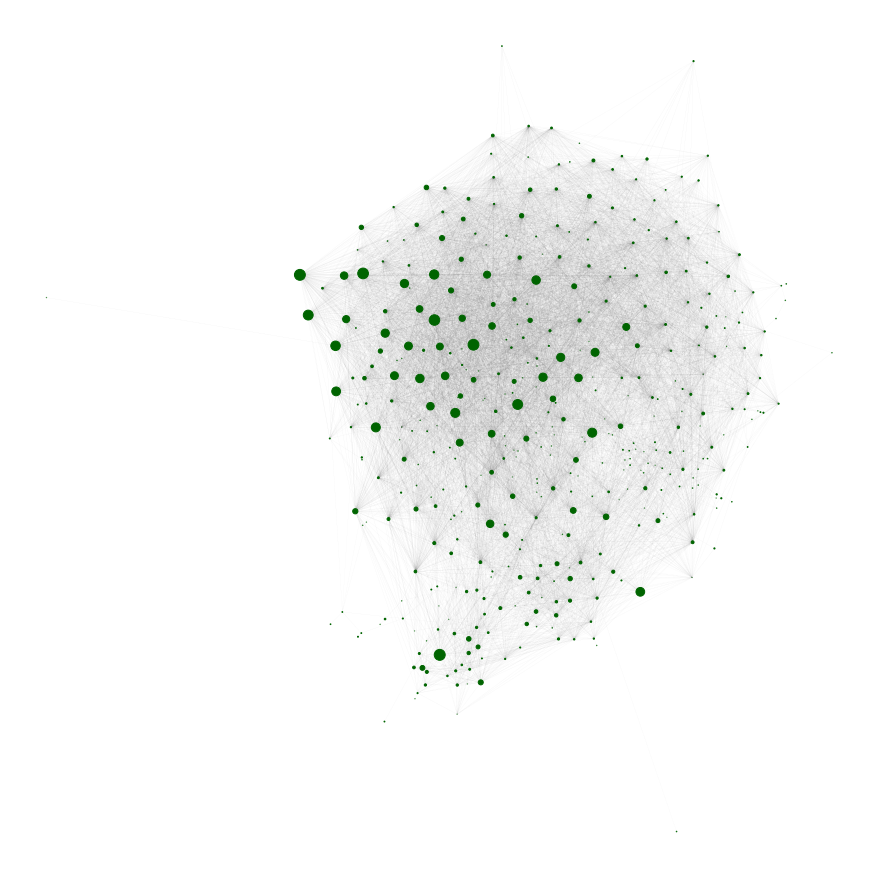

In [125]:
plt.figure(figsize = (12, 12))
plt.tight_layout()

nx.draw(G, pos = positions, node_size = node_sizes, node_color = 'darkgreen', width = 0.01)

The results of the graph plotting are very interesting: it seems that some hotels which are not so popular are having similar degree of connecting as the very popular nodes in the network. Therefore, it does not appear that there is a relationship between how popular a business is and how many competitors it has.

At the same time, it appears that there are many edge nodes which have fewer links to other nodes in the network than the majority. These results are just detected from eye-measuring the graph, and in order to make a responsible analysis with concrete numbers, we will have a look at the degree distribution of this network, in order to check for any network effects there. 

However, before checking the degree distribution, we wanted to take the graph visualizations to a dynamical space, where we can actually manipulate and zoom into the graph's structure in order to understand its connections, since this is not a traditional easy-to-interpret graph. 

We will perform an interactive representation of the previous plot using the Python library ___`Plotly`___.

In [192]:
# Extract latitude of hotel corresponding to each node
lat = list(business_df[business_df.business_id.isin(G.nodes())].latitude)

# Extract longitude of hotel corresponding to each node
lon = list(business_df[business_df.business_id.isin(G.nodes())].longitude)

# Define position of nodes using latitude and longitude
position = dict(zip(G.nodes(), zip(lat, lon)))

# Use review_count (while minimizing it to a reasonable scale for plotting) to indicate the node size
node_size = list(business_df[business_df.business_id.isin(G.nodes())].review_count*0.005)

In [193]:
# Add position information of edges
for n, p in positions.items():
    G.nodes[n]['pos'] = p
    
edge_x = []
edge_y = []

for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

# Plot edges using position and other args
edge_trace_business = go.Scatter(x = edge_x, 
                                 y = edge_y,
                                 line = dict(width = 0.01, color = 'darkred'),
                                 hoverinfo = 'none',
                                 mode = 'lines')

In [194]:
# Add position information of nodes
node_x = []
node_y = []

for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)

# Plot nodes using position and other args
node_trace_business = go.Scatter(x = node_x, 
                                 y = node_y,
                                 mode = 'markers',
                                 hoverinfo = 'text',
                                 marker = dict(showscale = True,
                                               colorscale = 'Blackbody',
                                               reversescale = True,
                                               color = [],
                                               size = node_size,
                                               colorbar = dict(thickness = 15,
                                                               title = 'Node Connections',
                                                               xanchor = 'left',
                                                               titleside = 'right'), 
                                               line_width = 2))

In [195]:
node_adjacency = []
node_text = []
node_names = []

for node in G.adjacency():
    # Store the adjacency of nodes into a list
    node_adjacency.append(len(node[1]))
    
    # Store the explanatory texts to indicate the number of adjacency for the plot
    node_text.append('# of connections: ' + str(len(node[1])))
    
    # Extract the names of nodes/hotels to show on plot
    node_names.append(nx.get_node_attributes(G, 'business_name')[node[0]])

In [196]:
# Assign different colors for different sizes of the adjacency number
node_trace_business.marker.color = node_adjacency

# Combine names and explanatory texts of nodes for plotting
node_trace_business.text = list(zip(node_names, node_text))

Plotly will use the original Force-Atlas positions of each hotel to plot a representational graph, where the nodes are holding the exact same coordinates as for the static plot seen above.

In [198]:
# Plot interactive graph
fig_network_business = go.Figure(data = [edge_trace_business, node_trace_business],
                                 layout = go.Layout(plot_bgcolor = 'white',
                                                    title = 'Hotels Network',
                                                    titlefont_size = 20,
                                                    showlegend = False,
                                                    hovermode = 'closest',
                                                    margin = dict(b=0, l=0, r=0, t=60),
                                                    annotations = [dict(showarrow = False,
                                                                        text = 'Interactive visualization of the Yelp hotels network in Las Vegas',
                                                                        xref = 'paper', 
                                                                        yref = 'paper',
                                                                        x = 0.005, 
                                                                        y = -0.002)],
                                                    xaxis = dict(showgrid = False, zeroline = False, showticklabels = False),
                                                    yaxis = dict(showgrid = False, zeroline = False, showticklabels = False)))

# fig_network_business.show()

_Screenshot image, since the Plotly interactive graph does not show without re-running the notebook:_

![Image of Hotels Network Graph](https://i.imgur.com/giMQAjU.png)

_**In order to view the above dynamic visualization "in action", please find it on our website, with link [here](https://hanlululu.github.io/SocialGraphYelp.io/Page3_Network.html).**_

By hovering over the interactive graph, we are able to find how many connections each hotel has with its neighbors/competitors. It can be clearly seen that the most popular nodes are also some of the ones with highest degree of connection, meaning that they share a larger number of competitors than most other businesses (___let's remember that node size is solely determined by the number of reviews a hotel received___).

<a id='5.3.'></a>
### 5.3. Degree distribution & comparison with random network

The visualization of the hotel network graph is slightly challenging to interpret, since, on one hand it doesn't seem to exhibit strong Barabasi-Albert properties, however on the other hand, it does not seem for the nodes to be connected randomly either. 

One way to verify whether such assumptions are correct is by plotting the linear and log-log degree distribution of the network, as done below.

The network edges are weight-adjusted depending on the number of common review keyworks, with higher thickness/weight meaning higher number of common keywords found.

In [199]:
degree_list = [x[1] for x in list(G.degree())]

max_degree = max(degree_list)
min_degree = min(degree_list)

print('The maximum degree in our network is:', max_degree)
print('The minimum degree in our network is:', min_degree)

The maximum degree in our network is: 160
The minimum degree in our network is: 1


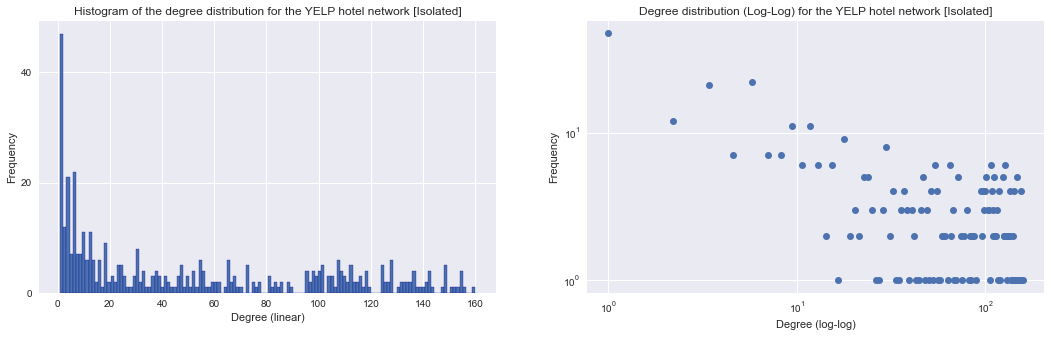

In [200]:
hist, bins = np.histogram(degree_list, bins = len(set(degree_list)))

fig, axs = plt.subplots(1, 2, figsize = (18, 5))

counts = axs[0].hist(degree_list, bins = bins, ec = "darkblue")
axs[0].set_title('Histogram of the degree distribution for the YELP hotel network [Isolated]')
axs[0].set_yticks(ticks = range(0, max(hist) + 1, 20));
axs[0].set_xlabel('Degree (linear)')
axs[0].set_ylabel('Frequency')

axs[1].loglog(bins[:-1], hist, 'bo', markersize = 7)
axs[1].set_title('Degree distribution (Log-Log) for the YELP hotel network [Isolated]')
axs[1].set_xlabel('Degree (log-log)')
axs[1].set_ylabel('Frequency');

As we can see above, there seems to be some form of a weak scale-free behavior in the network, since the log "degree distribution" tends to follow a power law, albeit with a rather large number of deviations from such behavior. 

Another sign which demonstrates the weak presence of a scale-free influence in the graph is the large maximum degree number present in the dataset, indicating the presence of a certain number of hubs, although the linear scale demonstrates that the distribution has many modes and a large number local minima points, thus deviating from the expected behavior of Barabasi-Albert graphs. The minimum degree number being $1$ also is a sign referring to a BA-graph behaviour, since, after all, a BA network a fully connected graph.

Let us try to compare these results with the results of a random network having the same number of starting nodes and a probability $p$ of connection to other nodes. The network that we will compare against is an __undirected Erdős-Rényi (random) graph__, with $p$ being computed by calculation upon the degrees of our hotel network.

Let us first compute $p$ below, knowing that $p = \frac{<k>}{N-1}$:

In [201]:
# Calculate the average of all degrees in the Hotels graph
k = np.mean([x[1] for x in list(G.degree())])

# N is the total number of nodes
N = G.number_of_nodes()

In [202]:
p = k / (N - 1)
print('The value of "p" is:', p)

The value of "p" is: 0.1220450175319534


Now, let us generate the (undirected) random network:

In [203]:
random_G = nx.fast_gnp_random_graph(n = N, p = p, seed = 3, directed = True)

Finally, let us take a look at the degree distribution for the random network, and see how it compares with the previous results from our Hotels network:

In [204]:
# Here, we have discarded the nodes with degree 0
degree_list = [x[1] for x in list(random_G.degree()) if x[1] != 0]

max_degree = max(degree_list)
min_degree = min(degree_list)

print('The maximum degree in the random network is:', max_degree)
print('The minimum degree in the random network is:', min_degree)

The maximum degree in the random network is: 128
The minimum degree in the random network is: 77


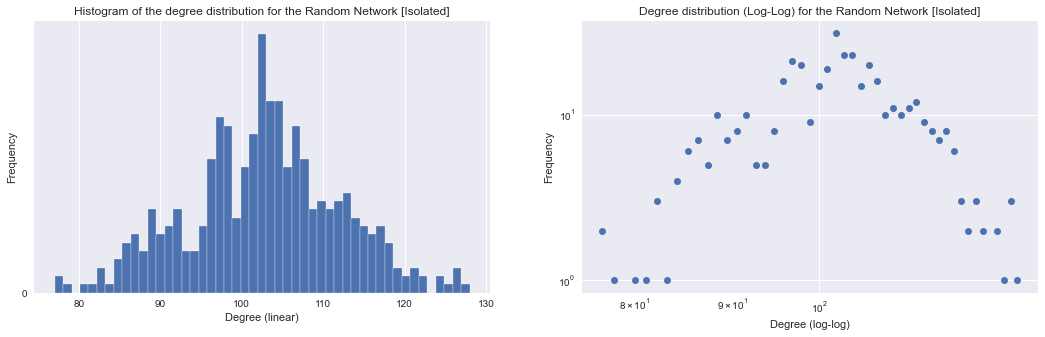

In [205]:
hist, bins = np.histogram(degree_list, bins = len(set(degree_list)))

fig, axs = plt.subplots(1, 2, figsize = (18, 5))

counts = axs[0].hist(degree_list, bins = bins, ec = "white")
axs[0].set_title('Histogram of the degree distribution for the Random Network [Isolated]')
axs[0].set_yticks(ticks = range(0, max(hist) + 1, 100));
axs[0].set_xlabel('Degree (linear)')
axs[0].set_ylabel('Frequency')

axs[1].loglog(bins[:-1], hist, 'bo', markersize = 7)
axs[1].set_title('Degree distribution (Log-Log) for the Random Network [Isolated]')
axs[1].set_xlabel('Degree (log-log)')
axs[1].set_ylabel('Frequency');

The degree distribution for the random network can easily be approximated with a Poisson distribution centered unimodally. This is very different than the scale-free behaviour we have seen in BA graphs, as well in our graph, where the distribution resembled a power law much more than a Poisson.

In conclusion, it seems that, in our Hotel network graph, there will be some "hubs" which will represent important competitors for most other hotels, even though the large selected number of top keywords available ($N = 10$) has generally given a significant "boost" to the degree values for all nodes across the entire span of the graph. 

<a id='5.4.'></a>
### 5.4. Network community detection & analysis

Looking at the original graph, it is good to visualize an overview of our Hotels network, however we are wondering if there are any groupings or clusters of hotels which are similar in terms of their special features or experiences (which get mentioned in users' reviews).

For this, we will try to compute and maximize the modularity score of each group of nodes through using the __Louvain__ algorithm, which looks as how much more densely connected the nodes in a community are, compared to how connected the same nodes would be in a random network. The Louvain algorithm is an unsupervised clustering method, and allows finding of the best partition of nodes into communities from a full-scale graph.

We will also set a set a seed for the algorithm, in order to achieve reproducibility of our results when re-running this project notebook:

In [206]:
# Find the best community partition for the DC universe
partition_hotels = community.best_partition(G, random_state = 3)

print("The Louvain algorithm has found", len(set(partition_hotels.values())), "communities for hotel landscape in Las Vegas.")

The Louvain algorithm has found 4 communities for hotel landscape in Las Vegas.


From the optimal partition, we have identified 4 communities which these hotels are grouped into. It is very important and relevant to visualize the distribution of each community's nodes across the original graph landscape, which is why we want to visualize the community graph.

The Force-Atlas positions computed previously will be kept and reused for this visualization, since then it allows for the graph layout to be preserved in its entirely, allowing us to only focus on the presence of communities.

In [207]:
# For this visualization, let us split the nodes by their community number
dict_communities = {}

for community_nr in range(0, max(partition_hotels.values()) + 1):
    dict_communities[community_nr] = [name for name, comm in partition_hotels.items() if comm == community_nr]

In [208]:
character_color_dict = {}
community_color_list = ['#00FA9A', '#0000FF', '#228B22', '#6495ED']

for community_nr, character_name_list in dict_communities.items():
    
    # For every node in this community, we assign them a previously-computed color
    for character_name in character_name_list:
        character_color_dict[character_name] = community_color_list[community_nr]
                
        
# The node colors in the DICT are not in the same order as the nodes in the graph, therefore we need to create a separate list to deal with that
node_color_list = []
# At the same time, we will create a list of node sizes by looking directly at the degree of each individual node (within the undirected Comics network)
node_size_list = []

for node in G:
    
    # Append the appropriate color to a node
    node_color_list.append(character_color_dict[node])

    # Append the appropriate size to a node
    node_size_list.append(G.degree(node) * 0.6)

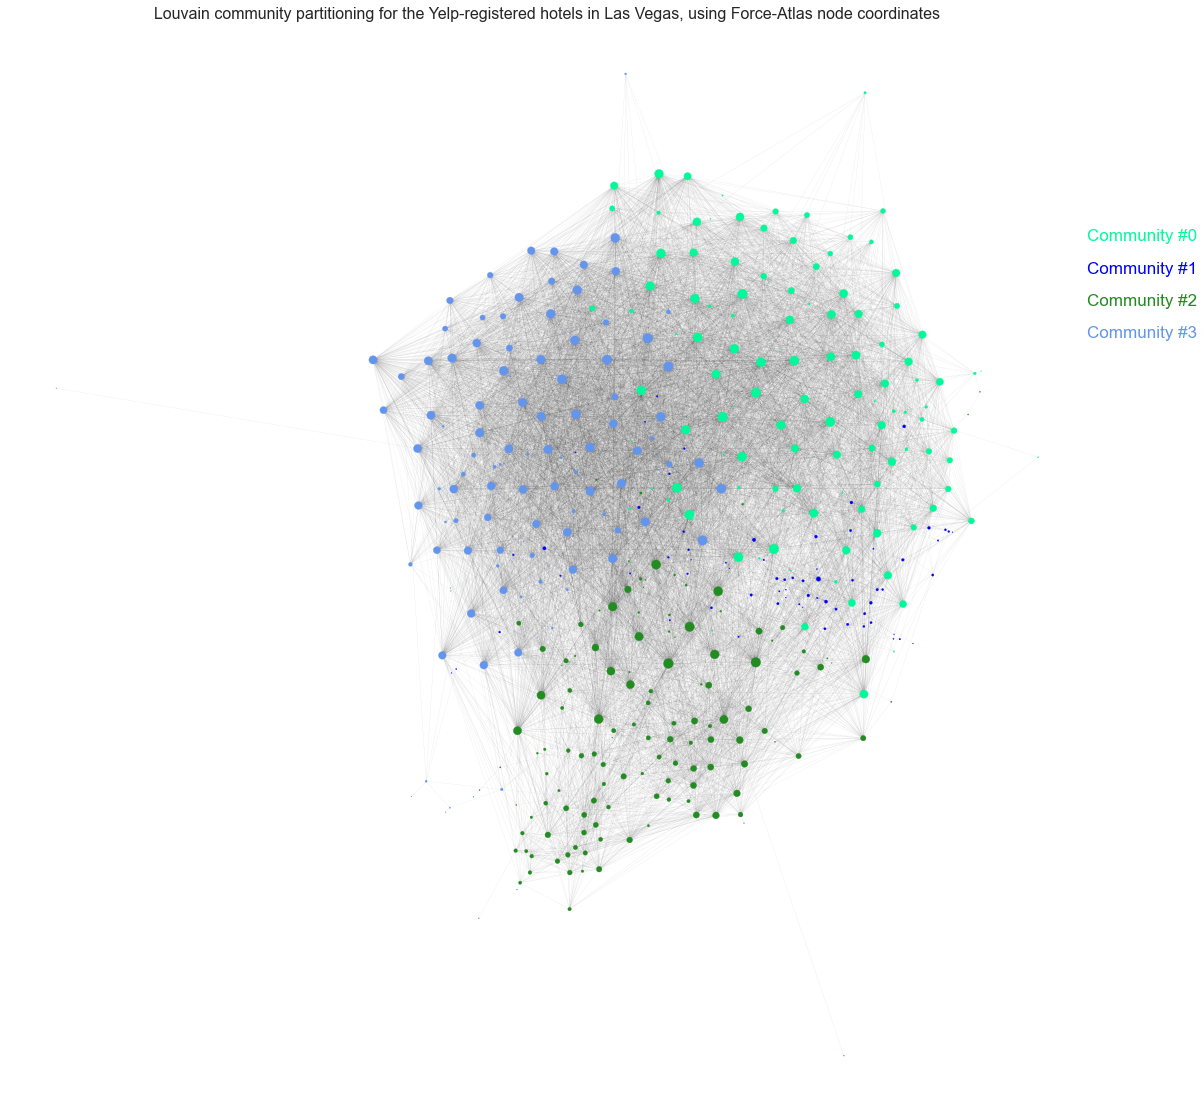

In [209]:
plt.figure(figsize = (15, 15))

# We will reuse the Force-Atlas positions computed previously, for consistency and efficiency
nx.draw(G, pos = positions, node_size = node_size_list, node_color = node_color_list, width = 0.025)

y = 0.80 # This is the starting Y, for the figure text
# Indicating community colors
for i in dict_communities.keys():
    plt.figtext(1, y, str('Community #' + str(i)), size = 17, color = community_color_list[i])
    y = y - 0.03

plt.title("Louvain community partitioning for the Yelp-registered hotels in Las Vegas, using Force-Atlas node coordinates", fontsize = 16);

The visual representation shows a clear separation of the network plot into the 4 communities, which is a very nice result. It seems that there are 3 large communities of approximatively similar sizes, and one smaller community whose nodes are scattered across the graph due to their interaction with a wide variety of hotels located all across the graph.

The plot shows that, for each community, there seems to interact a significant interaction with other community's nodes, although nodes from a community will always interact most with other nodes from the same community, as per the modularity maximization principle which the Louvain algorithm used for finding the best partition. This means that, although communities have been found, there are some top keywords which are shared highly by a large number of hotels across all communities.

Of course, besides the static visualization, an interactive method of finding __exactly which Hotels (identified by name) belong to which community__ can be useful. We will again use the ___`Plotly`___ library to show which businesses belong to which communities, in an aesthetically-pleasing manner.

In [210]:
# Add position information of edges
edge_trace_community = edge_trace_business

# Add position information of nodes
node_trace_community = node_trace_business

# Change color of edges
edge_trace_community['line']['color'] = 'darkred'

# Remove colorbar
node_trace_community['marker']['showscale'] = False

In [211]:
node_group = []
node_names = []

for node in G.adjacency():
    
    # Extract the names of nodes/hotels to show on plot
    node_names.append(nx.get_node_attributes(G, 'business_name')[node[0]])
    
    # Store the texts to indicates which community the node belongs to on the plot
    node_group.append('Community: '+ str([k for k,v in dict_communities.items() if node[0] in v]))

In [212]:
# Assign different colors to the nodes which belong to different communities 
# The color list is the same one used in community partition
node_trace_community.marker.color = node_color_list

# Combine names and explanatory texts of nodes for plotting
node_trace_community.text = list(zip(node_names, node_group))

In [214]:
# Plot interactive graph
fig_network_community = go.Figure(data = [edge_trace_community, node_trace_community],
                                  layout = go.Layout(plot_bgcolor = 'white',
                                  title = 'Communities Network',
                                  titlefont_size = 20,
                                  showlegend = False,
                                  hovermode = 'closest',
                                  margin = dict(b=0, l=0, r=0, t=60),
                                  annotations = [dict(showarrow = False,
                                                      text = 'Interactive visualization of the Yelp communities of hotels in Las Vegas',
                                                      xref = 'paper', 
                                                      yref = 'paper',
                                                      x = 0.005, 
                                                      y = -0.002)],
                                  xaxis = dict(showgrid = False, zeroline = False, showticklabels = False),
                                  yaxis = dict(showgrid = False, zeroline = False, showticklabels = False)))

# fig_network_community.show()

_Screenshot image, since the Plotly interactive graph does not show without re-running the notebook:_

![Image of Communities Network Graph](https://i.imgur.com/mhdxdu4.png)

_**In order to view the above dynamic visualization "in action", please find it on our website, with link [here](https://hanlululu.github.io/SocialGraphYelp.io/Page3_Network.html).**_

The visualization helps easily see that some of the very popular hotels are residing in Community 3, and that perhaps might have an important effect as to why they have been grouped together in the same community. 

By hovering over the interactive graph, we are able to find which hotels are belonging to what community.

<a id='5.5.'></a>
### 5.5. Community wordclouds 

Lastly in this network analysis project part, we will take a look at what words characterize each community. It is relevant to see this, in order to understand if there is a trend for why certain hotels were grouped together, and also for understanding what kind of experiences do you normally get from hotels in that community.

Firstly, we need to aggregate all the reviews for each community independently, and calculate TF, IDF and TF-IDF scores upon their aggregated reviews.

In [147]:
# Convert reviews of each community into one text for analysis
community_reviews = reviews(df = business_review_df, 
                            mode = 'community', 
                            dict_communities = dict_communities)

In [148]:
# Calculate term frequency of each community
community_term_frequency = tf(reviews = community_reviews, 
                              tf_method = 'term_frequency')

In [149]:
# Calculate inverse document frequency of each community
community_inverse_document_frequency = idf(reviews = community_reviews, 
                                           term_frequency = community_term_frequency, 
                                           idf_method = 'idf')

In [150]:
# Calculate TF-IDF score of each community
community_tf_idf = tf_idf(term_frequency = community_term_frequency, 
                          inverse_document_frequency = community_inverse_document_frequency)

The function below will convert separate words into a large text-string, which is necessary for feeding into the wordcloud:

In [151]:
# Function for converting the word dictionary into a string
def dict_to_string(word_dict, amplify=True):
    
    total_string = ''
    
    for word in word_dict:
        
        # If the tf-idf scores of words are too small, we times the original score by 1e8 for differentiating them better
        if amplify==True:
            repeat_nr = math.ceil(word_dict[word] * (10**8))
        
        else:
            repeat_nr = math.ceil(word_dict[word])
        
        # Create a string of one term (occuring, in a proportional manner, according to the TF-TR scores)
        string = ''.join([word + ' ' for count in range(repeat_nr)])
        
        # Concatenate the current elements to the total string
        total_string += string
        
    return total_string

In [152]:
text = {}
wordclouds = []
for comm in community_tf_idf.keys():
    text[comm] = dict_to_string(community_tf_idf[comm], False)

Here, we have decided to create wordclouds for each community in an interactive manner, with an "interactive twist". More specifically, through the use of the __IPython widgets__ function, we created a clickable drop-down menu for the community ID that you want to analyse words from, as well as another drop-down menu for the maximum number of words which should be shown in the wordcloud.

Since there are 4 communities, we decided to add a playful twist to the wordcloud figure, and represent each of them using the famous playing card suit set: _club, diamond, spade and heart_.

Here, the community wordclouds are represented, and by changing the options in the drop-down menu, different wordclouds come into view:

In [162]:
@interact   
def create_wordcloud(frame = fixed(text) , community = [0, 1, 2, 3], maximum = [50, 100, 300] , atitle = fixed('')):
    
    if community == 0:
        mk = imageio.imread('./project_files/club.jpg')
    if community == 1:
        mk = imageio.imread('./project_files/diamond.png')
    if community == 2:
        mk = imageio.imread('./project_files/spade.jpg')
    if community == 3:
        mk = imageio.imread('./project_files/heart.jpg')
   
    wordcloud = WordCloud(max_font_size = 70, 
                                       max_words = maximum, 
                                       background_color = 'white',
                                       collocations = False,
                                       mask = mk).generate(text[community])
    
    image_colors = ImageColorGenerator(mk)
    
    plt.style.use('seaborn')
    fig, ax = plt.subplots(figsize=[15, 15])
    ax.set_title(str('Wordcloud for community ' + str(community) + ' and the top ' + str(maximum) + ' most important words'), 
                 fontsize = 20)
    ax.imshow(wordcloud.recolor(color_func = image_colors), interpolation = 'bilinear')
    ax.axis('off')
    
# w = interact(create_wordcloud, 
#              frame = fixed(text), 
#              community = [0, 1, 2, 3], 
#              maximum = [50, 100, 300], 
#              atitle = fixed(''))

interactive(children=(Dropdown(description='community', options=(0, 1, 2, 3), value=0), Dropdown(description='…

_Screenshot image, since the @interact ipywidgets dropdown-menu does not show without re-running the notebook:_

![Image of the interactive wordclouds](https://i.imgur.com/g1wp0lX.png)

Unfortunately, because the interactive widgets cannot be saved in the Jupyter Notebook's state (without re-running the notebook again), besides the screenshot above showing you how they work, we will also create a traditional plot of wordclouds, in similar style to the one above:

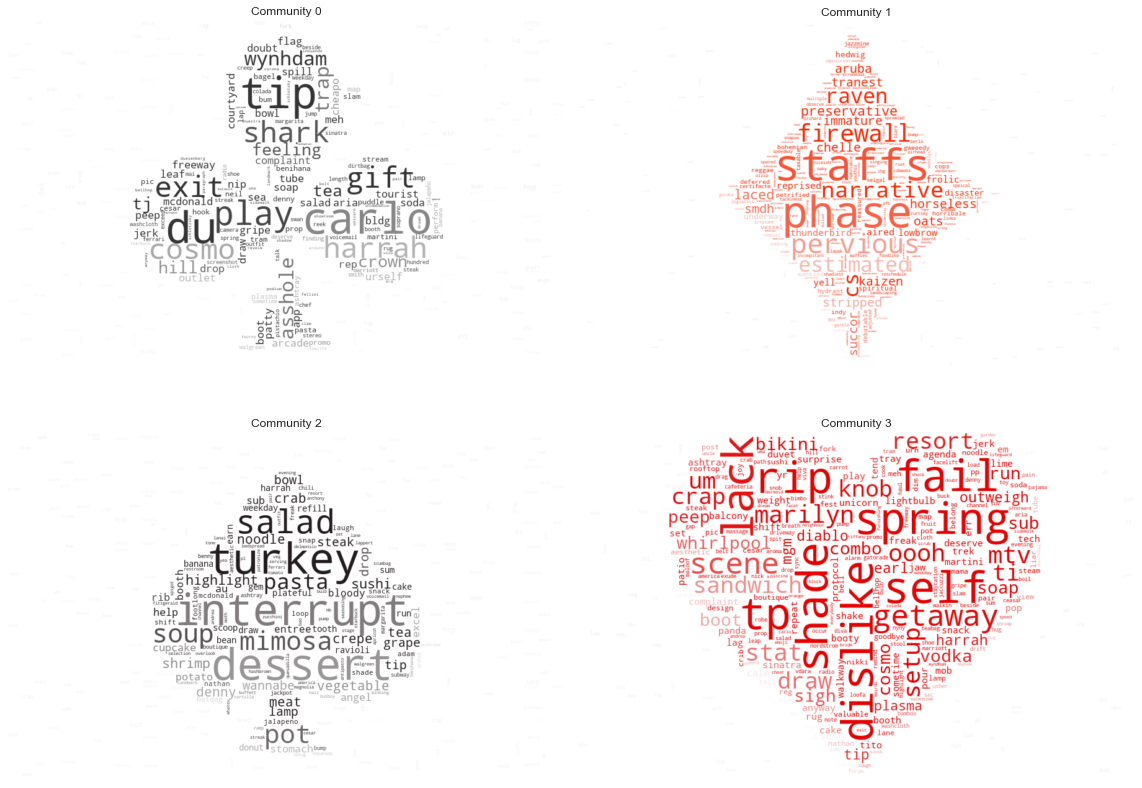

In [191]:
text = {}
wordclouds = []
colors = []

for comm in community_tf_idf.keys():
    text[comm] = dict_to_string(community_tf_idf[comm], False)
    
    # Static wordclouds (as interactive one does not show on the jupyter notebook)
    if comm == 0:
        mk = imageio.imread('./project_files/club.jpg')
    if comm == 1:
        mk = imageio.imread('./project_files/diamond.png')
    if comm == 2:
        mk = imageio.imread('./project_files/spade.jpg')
    if comm == 3:
        mk = imageio.imread('./project_files/heart.jpg')
   
    wordclouds.append(WordCloud(max_font_size = 70, 
                                                max_words = 300, 
                                                background_color = 'white',
                                                collocations = False,
                                                mask = mk).generate(text[comm]))
    colors.append(ImageColorGenerator(mk))
    
    
# Display the generated images
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
axs[0, 0].imshow(wordclouds[0].recolor(color_func = colors[0]), interpolation = 'bilinear')
axs[0, 0].set_title('Community 0')
axs[0, 0].axis('off')

axs[0, 1].imshow(wordclouds[1].recolor(color_func = colors[1]), interpolation = 'bilinear')
axs[0, 1].set_title('Community 1')
axs[0, 1].axis('off')

axs[1, 0].imshow(wordclouds[2].recolor(color_func = colors[2]), interpolation = 'bilinear')
axs[1, 0].set_title('Community 2')
axs[1, 0].axis('off')

axs[1, 1].imshow(wordclouds[3].recolor(color_func = colors[3]), interpolation = 'bilinear')
axs[1, 1].set_title('Community 3')
axs[1, 1].axis('off')

plt.tight_layout(pad = 1)

The community wordplot shows multiple very interesting and relevant findings:

* Community 0 contains many keywords related to casino ('_tip_', '_carlo_', '_shark'_, '_booth_', etc.), as well as words related to the adult night life of Las Vegas.


* Community 1 is the hardest one to pin-point. It seems that a central "theme" of the reviews belonging to hotels in this community is centered about the hotel staff, and words related to security. Later on, we will find that this community is also the one with the lowest sentiment score, which indicates that the comments regarding the staff here are not encouraging ones.


* Community 2 (_which we will later see that it is the happiest community_) is related very strongly to food, desserts and fruits. The hotels grouped in this community seem to have the common specialization in exquisite and delicious culinary adventures.


* Community 3 seems to have most words related to games, alcoholic drinking, as well as swear words, indicating that this community may be strongly involved with bar-hotels and the ones of a more "frivolous" nature.

--- 
<a id='6.'></a>
## 6. Topic detection using LDA

__Topic modelling__ is a tool for discovering hidden abstract semantic structures of texts, where __Latent Dirichlet allocation__ (known as LDA) as an unsupervised learning method is one way of performing topic modelling. 

Normally, LDA can be applied when we are trying to understand the latent topics in a large document collection without knowing what kind of topics there will be. The main idea of it is that ___each document can be described by a distribution of topics and each topic can be described by a distribution of words___. Applying LDA on a bag of words will result in several generated topics, each of which is composed of a distribution of keywords. 

After performing community detection using Louvain algorithm, the original dataset containing reviews has been split into 4 communities with their own wordclouds generated from reviews. 

Since the Louvain algorithm has given us 4 communities, upon which we have plotted 4 wordclouds (each corresponding to a community), we decided to use topic modelling to check whether the results from a completely different unsupervised method will generate similar word structure patterns as the ones we have for the wordclouds. In order to understand if these two methods (__LDA vs. wordclouds__) find similar features in clustering words, we have set the input number of topics to 4 in the LDA model.

In [215]:
# Convert reviews into bag of words
total_review_text = pd.DataFrame(list(business_reviews.items()), 
                                 columns = ['business_id', 'review']).review.apply(tokenize_text)

In [216]:
# Create dictionary of words
dictionary = corpora.Dictionary(total_review_text)

In [217]:
# Compute the term frequency of terms in each document
corpus = [dictionary.doc2bow(review) for review in total_review_text]

In [218]:
# Compute LDA model (num_topics = 4, since we want to compare the topics to the previous 4 wordclouds)
lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics = 4, id2word = dictionary, passes = 10)

In [222]:
print('The words and scores defining each topic are:')
lda_model.print_topics(num_topics = 4, num_words = 8)

The words and scores defining each topic are:


[(0,
  '0.030*"great" + 0.028*"nice" + 0.017*"good" + 0.012*"free" + 0.011*"clean" + 0.009*"beautiful" + 0.009*"next" + 0.009*"venetian"'),
 (1,
  '0.035*"great" + 0.028*"nice" + 0.026*"good" + 0.013*"clean" + 0.011*"free" + 0.009*"best" + 0.009*"next" + 0.009*"little"'),
 (2,
  '0.042*"good" + 0.030*"great" + 0.014*"best" + 0.014*"nice" + 0.010*"little" + 0.010*"much" + 0.010*"table" + 0.009*"bad"'),
 (3,
  '0.024*"good" + 0.021*"great" + 0.021*"nice" + 0.016*"clean" + 0.013*"old" + 0.012*"free" + 0.012*"bad" + 0.012*"new"')]

Once you provide the algorithm with the number of topics, it will rearrange the topic distribution in the document, as well as the keyword distribution within the topic, in order to get a good combination of topic-keyword distribution. 

Let us interactively check for the different kinds of relevant terms in each of the topic. The following visualization makes use of Jupyter notebook's interactivity, in order to dynamically the top 30 most relevant keywords, depending on a relevance metric $\lambda$.

In [ ]:
vis = pyLDAvis.gensim.prepare(topic_model = lda_model, corpus = corpus, dictionary = dictionary)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

Unfortunately, since the dynamic user interface requires the notebook to be run before displaying, let us show a screenshot with the user interface in action, to get an example of how it behaves.

_Screenshot image, since the pyLDAviz UI does not show without re-running the notebook:_

![Image of the LDA user interface](https://i.imgur.com/vxQa6Ei.png)

_**In order to view the above dynamic visualization "in action", please find it on our website, with link [here](https://hanlululu.github.io/SocialGraphYelp.io/Page3_Network.html).**_

After using the LDA algorithm to find 4 large topics, it can be observed that the topics do indeed have a number of similar words shown in wordclouds (which is created through Louvain for partitioning and TF-IDF for scoring). 

For example, topic 4 presented here is clearly showing words related to food and dessert, such as: '_salad_', '_steak_' or '_buffet_', which is very similar to the words shown in the wordcloud for community 2. 

Since the bag of words used for LDA has not been cleaned by TF-IDF to remove commom words, some topics will share several words with little information power (such as '_great_' or '_good_').

The value of $\lambda$, which is used to compute the most relevant terms for each topic, has been set to 0.6, as research literature ([Sievert & Sherley, 2014](https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf)) mentions this to be "optimal value" for identifing topic keywords.

--- 
<a id='7.'></a>
## 7. Sentiment Analysis upon the hotel reviews

<a id='7.1.'></a>
### 7.1. Finding the sentiment trends

Finally for our project, we are interested in understanding which hotels were given the most positive reviews and which hotels were performing poorest. Since there is a large set of reviews written by independent users, we can suggest that, by performing sentiment analysis upon the aggregated reviews for each hotel in part, we will be able to find the best hotels in Las Vegas.

Our sentiment analysis is dependent on an initial set of words which have sentiment scoring, used for comparing back to the words found in our reviews.

This happens to be one of major researches of Prof. __Finn Årup Nielsen__, researcher at DTU Compute, which created the __[AFINN](https://github.com/fnielsen/afinn) dataset__. AFINN is a list of words rated for sentimental valence, and scored on an integer scale between -5 (negative) and 5 (positive). Therefore, a completely neutral word or sentence would have a score of 0. This dataset has been updated several times throughout the years, with the latest update being in 2015. This is the dataset which we are using.

In [223]:
afinn = pd.read_csv('./project_files/AFINN-165.txt', sep="\t", skiprows = 2, header = None).rename(columns = {0: 'word', 1: 'sentiment_score'})

afinn.head(5)

word  sentiment_score
0    abandons               -2
1    abducted               -2
2   abduction               -2
3  abductions               -2
4       abhor               -3

In [224]:
# Create a dictionary containing the avg happiness score of each word from AFINN

afinn_sentiment_score = dict(zip(afinn['word'], afinn['sentiment_score']))

In order to compute sentiment score of each business or community, we create a function to realize the following steps:

* Extract words from reviews
* Remove stopwords to minimize the influence of the most common words (which often do not indicate emotional feelings on purpose)
* Use AFINN-165 sentiment score dictionary (as reference) to obtain the sentiment score of each word
* Sum up the sentiment scores of each word shown in the review text and compute the average sentiment by dividing the number of words

In [225]:
def sentiment_score(reviews, remove_stopwords, sentiment_score = afinn_sentiment_score):
    # Create a dictionary for storing the sentiment score of each community or business
    sentiment = {}
    
    # Get the set of stopwords
    stop_words = set(stopwords.words('english'))  
    
    # For each community or business
    for comm in reviews.keys():
        
        # Tokenize the original review, only extracting words and setting words to lowercase
        words = word_tokenize(re.sub('[^a-zA-Z\s]', ' ', reviews[comm]).lower())
          
        # Remove stopwords
        if remove_stopwords:
            words = [word for word in words if word not in stop_words]
            
        # Create the sentiment list of each word in the word list which also has a sentiment score in LabMT, of each community or business
        sentiments = [sentiment_score[word] for word in words if word in sentiment_score.keys()]
        
        # Compute the average sentiment score and round it
        avg_sentiment = round(np.mean(sentiments), 3)
        
        #  Store avg sentiment for each community or business
        sentiment[comm] = avg_sentiment
    
    return sentiment

Now we are able to calculate the sentiment score of each business/hotel:

In [226]:
business_sentiment_without_stopwords = sentiment_score(business_reviews, remove_stopwords = True)
business_sentiment_with_stopwords = sentiment_score(business_reviews, remove_stopwords = False)

In [227]:
# Sort business sentiment by its value for plotting histogram

business_sentiment_without_stopwords_sorted = sorted([v for k, v in business_sentiment_without_stopwords.items()], reverse = True)
business_sentiment_with_stopwords_sorted = sorted([v for k, v in business_sentiment_with_stopwords.items()], reverse = True)

We will plot the histogram of scores __with__ and __without__ stopwords, across all the hotels in Las Vegas.

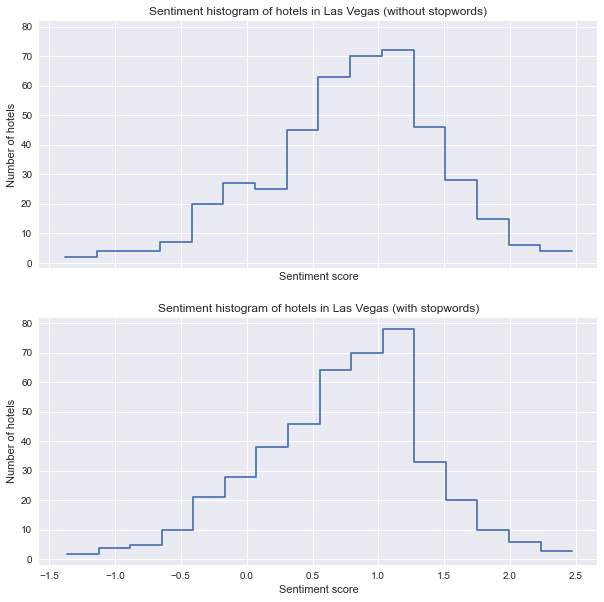

In [228]:
# Plot the histogram of sentiment scores over each hotel
fig, ax = plt.subplots(2, 1, figsize = (10, 10), sharex = True, sharey = True)

hist_without_stopwords, bin_edge_without_stopwords = np.histogram(business_sentiment_without_stopwords_sorted, bins = 16)
ax[0].plot(bin_edge_without_stopwords, np.insert(hist_without_stopwords, 0, hist_without_stopwords[0]), drawstyle = 'steps')
ax[0].set_title('Sentiment histogram of hotels in Las Vegas (without stopwords)')
ax[0].set_ylabel('Number of hotels')
ax[0].set_xlabel('Sentiment score')

hist_with_stopwords, bin_edge_with_stopwords = np.histogram(business_sentiment_with_stopwords_sorted, bins = 16)
ax[1].plot(bin_edge_with_stopwords, np.insert(hist_with_stopwords, 0, hist_with_stopwords[0]), drawstyle = 'steps')
ax[1].set_title('Sentiment histogram of hotels in Las Vegas (with stopwords)')
ax[1].set_ylabel('Number of hotels')
ax[1].set_xlabel('Sentiment score')

plt.show()

From the histogram of sentiment-score distribution over hotels, it can be noticed that the sentiment scores are ranging between $(-1.5, 2.5)$ and follow a positively skewed distribution, which indicates that the overall distribution of all hotels is slightly emotionally positive. 

Also, we are able to observe that the sentiment-score distribution of the diagram __'without stopwords'__ seems to spread out slightly more than __'with stopwords'__, which is a consequence of the fact that the stopwords are often neutral. However, in general, these two cases are following a similar trend in terms of distribution shape, therefore __only the version with stopwords will be considered in the subsequent analysis__, so as to guarantee the accuracy of sentiment scores.

Next, let us look at the "best and worst" hotels, meaning the hotels where the sentiment scores are most positive or most negative:

In [229]:
# Add sentiment score to business_df
business_df['sentiment'] = business_df['business_id'].map(business_sentiment_with_stopwords)  

In our dataset, there already is an aggregate "rating" score (from 1 to 5) corresponding to the average of the number of stars that a hotel accumulated across all its user reviews.

We would like to try and understand if there is any relationship between the sentiment scores we find and the ratings of such hotels:

In [231]:
i = 1

# Sort the sentiment score dictionary of businesses by value from highest to lowest and pick top 10
for key, value in sorted(business_sentiment_with_stopwords.items(), key = lambda x:x[1], reverse = True)[:10]:
    print('#{} {} - Sentiment: {}, Rating: {}'.format(i, 
                                                      business_df[business_df.business_id == key].name.values[0], 
                                                      value, 
                                                      business_df[business_df.business_id == key].stars.values[0]))
    i += 1

#1 Roberta's Steakhouse - Sentiment: 2.471, Rating: 4.5
#2 Team Kaizen - Sentiment: 2.303, Rating: 5.0
#3 Sands Hotel - Sentiment: 2.25, Rating: 4.5
#4 Fortunes - Sentiment: 2.2, Rating: 3.5
#5 Jennifer Romas' Sexxy - Sentiment: 2.087, Rating: 4.5
#6 Star Motel - Sentiment: 2.067, Rating: 4.5
#7 Lip Smacking Foodie Tours - Sentiment: 2.053, Rating: 5.0
#8 Venetian Casino Grazie Club Gold Room - Sentiment: 2.033, Rating: 4.0
#9 Las Vegas Strip Trips - Sentiment: 2.027, Rating: 5.0
#10 HGVClub - Sentiment: 1.941, Rating: 4.5


In [232]:
i = 1
# Sort the sentiment score dictionary of businesses by value from highest to lowest and pick top 10
for key, value in sorted(business_sentiment_with_stopwords.items(), key = lambda x:x[1], reverse = False)[:10]:
    print('#{} {} - Sentiment: {}, Rating: {}'.format(i,
                                                      business_df[business_df.business_id == key].name.values[0], 
                                                      value, 
                                                      business_df[business_df.business_id == key].stars.values[0]))
    i += 1

#1 Exotic Escapes - Sentiment: -1.364, Rating: 1.0
#2 Umpire - Sentiment: -1.222, Rating: 1.0
#3 Siegel Suites - Sentiment: -1.091, Rating: 2.0
#4 Las Vegas Villa - Sentiment: -0.962, Rating: 2.0
#5 Holiday Motel - Sentiment: -0.926, Rating: 1.5
#6 Desert Star Motel - Sentiment: -0.907, Rating: 1.5
#7 Holiday House Holiday Motel - Sentiment: -0.741, Rating: 2.0
#8 Lamplighter Motel - Sentiment: -0.72, Rating: 1.0
#9 Siegel Suites Bonanza - Sentiment: -0.706, Rating: 1.0
#10 Sahara Westwood Hotel - Sentiment: -0.697, Rating: 1.0


It can be clearly seen that hotels with most positive sentiment scores are also rated relatively high, and vice versa, which shows consistency between sentiment scores and rating scores.

When it comes to the communities, there are many possible discussions regarding sentiment score, however here, we will be interested in showing what each community's overall sentiment is. 

In [233]:
community_sentiment_with_stopwords = sentiment_score(community_reviews, remove_stopwords = False)

In [234]:
print(community_sentiment_with_stopwords)

{0: 0.63, 1: 0.369, 2: 0.932, 3: 0.928}


Since we already have looked at the community wordclouds in a previous section, we can see that the results fall very well in line with our findings: community nr. 1 was the community which contained most top keywords as negative or inappropriate words, such as '_immature_', '_disaster_' or '_strip_'. 

As it can be noted, the overall community score is not very far from neutral, since the number of reviews for each community is very large, and therefore strong sentiments on either positive or negative scales 'cancel out', and the general trend becomes almost-neutral.

<a id='7.2.'></a>
### 7.2. Temporal sentiment geomapping

Now that we have identified the general sentiment trends across our Yelp Hotels dataset, it is important to also link these sentiments to the geo-temporal dimension that our dataset comes from. In other words, we know that each hotel is located at a specific (latitude, longitude) location, and that every review has been written at a certain date and hour in time.

We will use these two dimensions to analyze an interactive geo-map, where we position the hotels according to their location on the map, and their sentiment scores in the time domain will dictate the color of their node.

The following two cases are considered:

1. Seasonal temporal map, where we will check if sentiment scores change based on the year quarter (_e.g. Q1 - January to March, etc._) in which they were written;

2. Time-of-day temporal map, where we will check the trend of sentiment scores across the 5 different times of day during which they were written (morning, noon, afternoon, evening, night);

In [235]:
# Convert date object to datetime type
business_review_df.date = pd.to_datetime(business_review_df.date)

In [236]:
# Function for split date into quarters
def quarter(df):
    # Q1
    if (df.month >= 1) & (df.month < 4):
        return 'Q1'
    # Q2
    if (df.month >= 4) & (df.month < 7):
        return 'Q2'
    # Q3
    if (df.month >= 7) & (df.month < 10):
        return 'Q3'
    # Q4
    if (df.month >= 10) & (df.month <= 12):
        return 'Q4'

In [237]:
# Function for split date into quarters
def hour(df):
    # Midnight
    if (df.hour >= 0) & (df.hour < 6):
        return 'Night'
    # Morning
    if (df.hour >= 6) & (df.hour < 11):
        return 'Morning'
    # Noon
    if (df.hour >= 11) & (df.hour < 14):
        return 'Noon'   
    # Afternoon
    if (df.hour >= 14) & (df.hour < 18):
        return 'Afternoon'  
    # Night
    if (df.hour >= 18) & (df.hour <= 23):
        return 'Evening'      

In [238]:
business_review_df['quarter'] = business_review_df.date.apply(quarter)
business_review_df['day_time'] = business_review_df.date.apply(hour)

<a id='7.2.1.'></a>
#### 7.2.1.  Geomap of the overall sentiment score

This first geomap is showing the overall sentiments across each hotel in Las Vegas. This visualization does not take into account any temporal domain separation, and is included as a baseline reference of how the Las Vegas landscape looks like, in terms of sentiment analysis.

In [250]:
fig_all_sentiment = px.scatter_mapbox(business_df,
                                      lat = 'latitude',
                                      lon = 'longitude',
                                      hover_name = 'name', 
                                      hover_data = ['top_keywords'],
                                      color = 'sentiment', 
                                      color_continuous_scale = 'balance', 
                                      size = 'review_count', 
                                      zoom = 10, 
                                      height = 300)

fig_all_sentiment.update_layout(mapbox_style='carto-positron')
fig_all_sentiment.update_layout(margin={'r': 0, 't': 0, 'l': 0, 'b': 0})

# fig_all_sentiment.show()

_Screenshot image, since the Plotly interactive graph does not show without re-running the notebook:_

![Image of overall sentiment geo-map](https://i.imgur.com/e3hLZM4.png)

_**In order to view the above dynamic visualization "in action", please find it on our website, with link [here](https://hanlululu.github.io/SocialGraphYelp.io/Page4_Sentiment.html).**_

As we can see, most hotels have a slighly positive experience rating, with the ones in the center of the city being more inclined to have a better overall score, while the perifery of the city shows some hotels with a rather neutral outlook.

<a id='7.2.2.'></a>
#### 7.2.2. Seasonal temporal map (based on yearly quarters)

For our second geomap, we will compute sentiment scores of businesses in each quarter of year, to see if there is any variation between seasons. Based on the segmentation of time, now it is possible to compute the sentiment score for every hotel during each time-period:

In [240]:
def temporal_sentiment(business_review_df, business_df, mode):
    if mode == 'quarter':
        # For each quarter
        for q in business_review_df.quarter.unique():
            
            #  Filter the business_review_df according to specific quarter
            business_review_quarter_df = business_review_df[business_review_df.quarter == q]
            
            #  Combine reviews of each business
            business_reviews_quarter = reviews(df = business_review_quarter_df, mode = 'business')
            
            # Compute the sentiment score dictionary of each business in a quarter
            business_sentiment_quarter = sentiment_score(business_reviews_quarter, remove_stopwords = False)
            
            #  Add sentiment dictionary of each quarter as a column to business_df
            business_df['sentiment_'+q] = business_df['business_id'].map(business_sentiment_quarter)     
            business_df['sentiment_'+q] = business_df['sentiment_'+q].fillna(0)
    
    if mode == 'day_time':
        for time in business_review_df.day_time.unique():
            
            #  Filter the business_review_df according to specific day time
            business_review_hour_df = business_review_df[business_review_df.day_time == time]
            
            #  Combine reviews of each business
            business_reviews_hour = reviews(df = business_review_hour_df, mode = 'business')
            
            # Compute the sentiment score dictionary of each business within a certain day time
            business_sentiment_hour = sentiment_score(business_reviews_hour, remove_stopwords = False)
            
            #  Add sentiment dictionary of each day time as a column to business_df
            business_df['sentiment_'+time] = business_df['business_id'].map(business_sentiment_hour)
            business_df['sentiment_'+time] = business_df['sentiment_'+time].fillna(0)
    
    return  business_df

In [241]:
business_df = temporal_sentiment(business_review_df = business_review_df, business_df = business_df, mode = 'quarter')
business_df = temporal_sentiment(business_review_df = business_review_df, business_df = business_df, mode = 'day_time')

In [251]:
# Plot sentiment geomaps of different quarters of year
fig_quarter = px.scatter_mapbox(business_df, 
                                lat = 'latitude',
                                lon = 'longitude',
                                hover_name = 'name', 
                                hover_data = ['top_keywords'],
                                color =  'sentiment_Q1',
                                color_continuous_scale = 'balance', 
                                size = 'review_count', 
                                zoom = 10, 
                                height = 300)

fig_quarter.add_trace(px.scatter_mapbox(business_df,
                                        lat = 'latitude',
                                        lon = 'longitude',
                                        hover_name = 'name', 
                                        hover_data = ['top_keywords'],
                                        color =  'sentiment_Q2',
                                        color_continuous_scale = 'balance', 
                                        size = 'review_count', 
                                        zoom = 10, 
                                        height = 300).data[0])

fig_quarter.add_trace(px.scatter_mapbox(business_df,
                                        lat = 'latitude',
                                        lon = 'longitude',
                                        hover_name = 'name', 
                                        hover_data = ['top_keywords'],
                                        color =  'sentiment_Q3',
                                        color_continuous_scale = 'balance', 
                                        size = 'review_count', 
                                        zoom = 10, 
                                        height = 300).data[0])

fig_quarter.add_trace(px.scatter_mapbox(business_df,
                                        lat = 'latitude',
                                        lon = 'longitude',
                                        hover_name = 'name', 
                                        hover_data = ['top_keywords'],
                                        color =  'sentiment_Q4',
                                        color_continuous_scale = 'balance', 
                                        size = 'review_count', 
                                        zoom = 10, 
                                        height = 300).data[0])

# Add button
updatemenus = [dict(type = "buttons", direction = "down",
                    buttons = list([
                        dict(args=[{'visible': [True, False, False, False]}, 'type'],
                             label = "Q1", 
                             method="update"),

                        dict(args=[{'visible': [False, True, False, False]}, 'type'],
                             label = "Q2", 
                             method="update"),
                                   
                        dict(args=[{'visible': [False, False, True, False]}, 'type'],
                            label = "Q3", 
                            method="update"),
                                   
                        dict(args=[{'visible': [False, False, False, True]}, 'type'],
                            label = "Q4", 
                            method="update")
                    ]))]


fig_quarter.update_layout(updatemenus = updatemenus,
                         legend_title_text = 'Sentiment score over year quarters')
fig_quarter.update_layout(mapbox_style = 'carto-positron')
fig_quarter.update_layout(margin={'r': 0, 't': 0, 'l': 0, 'b': 0})

# fig_quarter.show()

_Screenshot image, since the Plotly interactive graph does not show without re-running the notebook:_

![Image of the seasonal temporal map](https://i.imgur.com/DdXgpbk.png)

_**In order to view the above dynamic visualization "in action", please find it on our website, with link [here](https://hanlululu.github.io/SocialGraphYelp.io/Page4_Sentiment.html).**_

Based on the interactive ___`plotly`___ visualization above, we can identify that most positive sentiment scores are given in Q1 of the year, meaning in the months between January & March (inclusive), while the lowest sentiment scores can be found from reviews written in the Q3 period of the year (meaning in the months of July, August & September).

It seems that this behavior is in connection with the both the higher tourist expectations, who generally arrive in the summer months, as well as the increased crime rate during the summertime (statistics found from US journalism house: [report here](https://www.governing.com/topics/public-justice-safety/gov-summer-crime-rates-increases-police.html)). 

<a id='7.2.3.'></a>
#### 7.2.3. Time-of-day temporal map

Our final geomap refers to the sentiment scores received by reviews, grouped by the time of day during which they were written. We are interested in seeing if there is any change between the different periods of a day during which a review is submitted. For that, we will again compute sentiment scores of businesses for each time of day individually, and use an interactive ___`plotly`___ visualization to show the differences in scores as changing node colors.

In [253]:
# Plot sentiment geomaps of different parts of day
fig_day = px.scatter_mapbox(business_df, 
                            lat = 'latitude',
                            lon = 'longitude',
                            hover_name = 'name', 
                            hover_data = ['top_keywords'],
                            color =  'sentiment_Morning',
                            color_continuous_scale = 'balance', 
                            size = 'review_count', 
                            zoom = 10, 
                            height = 300)

fig_day.add_trace(px.scatter_mapbox(business_df,
                                    lat = 'latitude',
                                    lon = 'longitude',
                                    hover_name = 'name', 
                                    hover_data = ['top_keywords'],
                                    color =  'sentiment_Noon',
                                    color_continuous_scale = 'balance', 
                                    size = 'review_count', 
                                    zoom = 10, 
                                    height = 300).data[0])

fig_day.add_trace(px.scatter_mapbox(business_df,
                                    lat = 'latitude',
                                    lon = 'longitude',
                                    hover_name = 'name', 
                                    hover_data = ['top_keywords'],
                                    color =  'sentiment_Afternoon',
                                    color_continuous_scale = 'balance', 
                                    size = 'review_count', 
                                    zoom = 10, 
                                    height = 300).data[0])

fig_day.add_trace(px.scatter_mapbox(business_df,
                                    lat = 'latitude',
                                    lon = 'longitude',
                                    hover_name = 'name', 
                                    hover_data = ['top_keywords'],
                                    color =  'sentiment_Evening',
                                    color_continuous_scale = 'balance', 
                                    size = 'review_count', 
                                    zoom = 10, 
                                    height = 300).data[0])

fig_day.add_trace(px.scatter_mapbox(business_df,
                                    lat = 'latitude',
                                    lon = 'longitude',
                                    hover_name = 'name', 
                                    hover_data = ['top_keywords'],
                                    color =  'sentiment_Night',
                                    color_continuous_scale = 'balance', 
                                    size = 'review_count', 
                                    zoom = 10, 
                                    height = 300).data[0])

# Add button
updatemenus = [dict(type = "buttons", direction = "down",
                    buttons = list([
                        dict(args=[{'visible': [True, False, False, False, False]}, 'type'],
                             label = "Morning", 
                             method="update"),
                        
                        dict(args=[{'visible': [False, True, False, False, False]}, 'type'],
                             label = "Noon", 
                             method="update"),
                                   
                        dict(args=[{'visible': [False, False, True, False, False]}, 'type'],
                             label = "Afternoon", 
                             method="update"),
                                   
                        dict(args=[{'visible': [False, False, False, True, False]}, 'type'],
                             label = "Evening", 
                             method="update"),
                                   
                        dict(args=[{'visible': [False, False, False, False, True]}, 'type'],
                             label = "Night", 
                             method="update")
                    ]))]


fig_day.update_layout(updatemenus = updatemenus,
                         legend_title_text = '')
fig_day.update_layout(mapbox_style='carto-positron')
fig_day.update_layout(margin={'r': 0, 't': 0, 'l': 0, 'b': 0})

fig_day.show()

_Screenshot image, since the Plotly interactive graph does not show without re-running the notebook:_

![Image of the time-of-day temporal map](https://i.imgur.com/DYEAHeH.png)

_**In order to view the above dynamic visualization "in action", please find it on our website, with link [here](https://hanlululu.github.io/SocialGraphYelp.io/Page4_Sentiment.html).**_

Through understanding the geomap above, we can clearly see that the least-positive reviews are written during the morning time (between 06:00 AM and 11:00 AM), with almost no hotel at all received an aggregated sentiment score above 1 (out of max. +5). In contrast, reviews written during the evening are the most positive, with aggregated sentiments for the same hotel crossing above the 1.00 score mark, and, for the best hotels, averaging around 1.7-1.8 in total. Reviews posted during the afternoon or nighttime seem to be more neutral than during the evening, however still manage to cross the borderline 0.00 score.

In general, this clearly shows a trend in the review-posting behavior of users, and by clicking the buttons of the visualization, one can get a quick overview that this trend is applicable across the vast majority of the hotels, making it a temporal trend effect (rather than localized behaviour of a specific hotel).

<a id='8.'></a>
## 8. Discussion

The project was completed successfully, with a good learning curve in terms of network visualizations, topic modelling, as well as NLP and graph theory. Interactive visualizations and maps were very useful for discovering trends in the data, and the temporal discussion of the sentiment scores (at the end of the project) was one of the most interesting parts to think about and try to unravel in ideas.

At the same time, it was slightly challenging to see that some of the interactive tools we were trying to use could not save their state without rerunning, when sharing the notebook further to others. That is something that it is good to take into consideration, however we have solved the problem by creating an interactive website for the dynamic visualizations, as well as posting static screenshots for reference.

One potential suggestion for further research is to take the network of users into consideration as well, so that businesses are connected indirectly by the users who commonly review them, thereby creating a bipartite-like network structure.